<h3><center>M7 Practical Challenge: Binary Logistic Regression
    <br>By Anna Imhoff, Randy Leon, and Jinming Chen</br></h3></center>

<h3><b>Introduction</b></h3>

The Insurance Company data used for this exercise can be found on [Kaggle](https://www.kaggle.com/rluyck/insurance-company?select=Customer_data.csv).  First, we will upload the data set to our Github repository.  The original data set contains over 14,106 observations and 15 attributes.  The response variable will be TARGET which represents yes (1) a new product was purchased or no (0) a new product was not purchased.  Exploratory data analysis will be performed on the variables to familiarize us with the insurance company attributes, identify trends and missing data, and gather preliminary predictive inferences.  We will apply feature selection and/or dimensionality reduction techniques to identify the explanatory variables to be included in a series of K-Nearest Neighbor and Support Vector Machine models that predict whether or not a given insurance company customer is likely to purchase an additional insurance product.

<b>Data Set Attributes</b><br> 

1) ID - Unique customer identifier (<b>categorical</b>) <br> 
2) TARGET - Indicator of buying the new product (0 = no, 1= yes) (<b>categorical, binary</b>)<br>
3) Loyalty - Loyalty level, from low to high (0 to 3), 99 = unclassified (<b>categorical, ordinal</b>) <br>
4) Age - Age in years (<b>numeric, discrete</b>) <br>
5) City - Unique code per city (<b>categorical</b>) <br>
6) Age_p - Age of partner in years (<b>numeric, discrete</b>) <br>
7) LOR - Length of relationship in years (<b>numeric, discrete</b>) <br>
8) LOR_m - Length of relationship in months (<b>numeric, discrete</b>)<br>
9) Prod_A - Bought Product A (0 = no, 1 = yes) (<b>categorical</b>) <br>
10) Type_A - Type of product A (<b>categorical</b>)<br>
11) Turnover_A - Amount of money spent on Product A (<b>numeric, continuous</b>) <br>
12) Prod_B - Bought Product B (0 = no, 1 = yes) (<b>categorical, binary</b>) <br>
13) Type_B - Type of product B (<b>categorical</b>) <br>
14) Turnover_B - Amount of money spent on Product B (<b>numeric, continuous</b>)<br>
15) Contract - Type of contract (<b>categorical</b>) <br>

In [1]:
#Import libraries and packages
import pandas as pd
import numpy as np

from scipy import stats
import matplotlib.pyplot as plt 
plt.rc("font", size=14)

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import neighbors, preprocessing, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score, classification_report, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

#Read in the csv from Github
df = pd.read_csv("https://raw.githubusercontent.com/annaimhoff/DAV-6150/main/M7_Data.csv", sep=',')
                 
#View the data frame
df.head()

,TARGET,loyalty,ID,age,city,LOR,prod_A,type_A,type_B,prod_B,turnover_A,turnover_B,contract,age_P,lor_M
0,N,99,12585,11,2,0,0,0,0,0,357.339500,249.741496,2,11,3
1,N,99,1119,13,2,0,0,0,0,0,351.427321,227.079688,2,13,3
2,N,99,75,14,2,0,0,0,0,0,345.609148,203.250249,2,14,3
3,N,99,11809,22,2,0,0,0,0,0,398.448554,218.960897,2,22,3
4,N,99,12296,22,2,0,0,0,0,0,355.744324,231.921720,2,22,3


We will drop the ID column since it is a unique identifier and will not be predictive.

In [2]:
#Drop the ID column since it is non-predictive
df = df.drop(df.columns[[2]], axis=1)

#View the data frame to ensure that the column was removed
df.head()

,TARGET,loyalty,age,city,LOR,prod_A,type_A,type_B,prod_B,turnover_A,turnover_B,contract,age_P,lor_M
0,N,99,11,2,0,0,0,0,0,357.339500,249.741496,2,11,3
1,N,99,13,2,0,0,0,0,0,351.427321,227.079688,2,13,3
2,N,99,14,2,0,0,0,0,0,345.609148,203.250249,2,14,3
3,N,99,22,2,0,0,0,0,0,398.448554,218.960897,2,22,3
4,N,99,22,2,0,0,0,0,0,355.744324,231.921720,2,22,3


<h3><b>Exploratory Data Analysis</b></h3>

Check to see if the predictor variable, TARGET, is balanced.

In [3]:
df['TARGET'].value_counts()

N    8000
Y    6016
Name: TARGET, dtype: int64

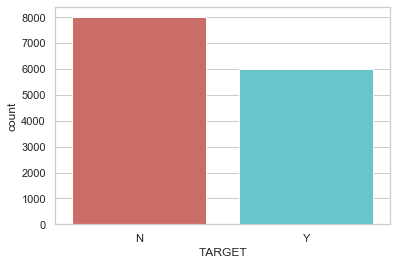

<Figure size 432x288 with 0 Axes>

In [4]:
sns.countplot(x='TARGET', data=df, palette='hls')
plt.show()
plt.savefig('count_plot')

In [5]:
count_no_prod = len(df[df['TARGET']=='N'])
count_prod = len(df[df['TARGET']=='Y'])
pct_of_no_prod = count_no_prod/(count_no_prod+count_prod)
print("% of no new product is purchased is", round(pct_of_no_prod*100))
pct_of_prod = count_prod/(count_no_prod+count_prod)
print("% of yes a new product is purchased is", round(pct_of_prod*100))

% of no new product is purchased is 57
% of yes a new product is purchased is 43


The classes of the predictor are fairly balanced.

Check for missing values

In [6]:
df.isnull().sum()

TARGET        0
loyalty       0
age           0
city          0
LOR           0
prod_A        0
type_A        0
type_B        0
prod_B        0
turnover_A    0
turnover_B    0
contract      0
age_P         0
lor_M         0
dtype: int64

We have no missing values in our data set.

Check to see if the data set size is sufficient.

In [7]:
#Check data types and size
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14016 entries, 0 to 14015
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TARGET      14016 non-null  object 
 1   loyalty     14016 non-null  int64  
 2   age         14016 non-null  int64  
 3   city        14016 non-null  int64  
 4   LOR         14016 non-null  int64  
 5   prod_A      14016 non-null  int64  
 6   type_A      14016 non-null  int64  
 7   type_B      14016 non-null  int64  
 8   prod_B      14016 non-null  int64  
 9   turnover_A  14016 non-null  float64
 10  turnover_B  14016 non-null  float64
 11  contract    14016 non-null  int64  
 12  age_P       14016 non-null  int64  
 13  lor_M       14016 non-null  int64  
dtypes: float64(2), int64(11), object(1)
memory usage: 1.5+ MB


We have 14,106 observations which is sufficient to build a logistic regression model.

Check that our target is binary or ordinal.

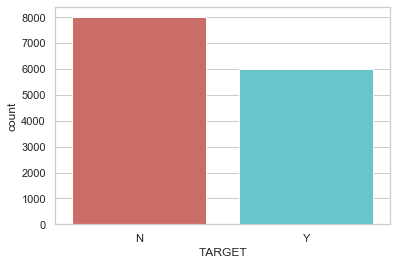

In [8]:
sns.countplot(x = 'TARGET', data = df, palette = 'hls')

Our target is Y/N so it will need to be changed to 1/0.

In [9]:
df = df.replace(to_replace = ['Y','N'],value = [1,0])

In [10]:
#View the data frame to ensure the changes were made
df.head()

,TARGET,loyalty,age,city,LOR,prod_A,type_A,type_B,prod_B,turnover_A,turnover_B,contract,age_P,lor_M
0,0,99,11,2,0,0,0,0,0,357.339500,249.741496,2,11,3
1,0,99,13,2,0,0,0,0,0,351.427321,227.079688,2,13,3
2,0,99,14,2,0,0,0,0,0,345.609148,203.250249,2,14,3
3,0,99,22,2,0,0,0,0,0,398.448554,218.960897,2,22,3
4,0,99,22,2,0,0,0,0,0,355.744324,231.921720,2,22,3


Next, let's look at the numeric attributes and categorical attributes more closely.

In [11]:
#Create lists of numerical and categorical attributes

col_cat=['TARGET', 'loyalty', 'city', 'prod_A', 'type_A', 'prod_B', 'type_B', 'contract']

col_num=['age', 'age_P', 'LOR', 'lor_M', 'turnover_A', 'turnover_B']

print("# of numerical attributes:%s" %len(col_num))
print("# of categorical attributes:%s" %len(col_cat))

# of numerical attributes:6
# of categorical attributes:8


<h4><b>Histograms, Bar Charts, Boxplots and Correlation Matrix</b></h4>

Plot a histogram for each of our numerical attributes.

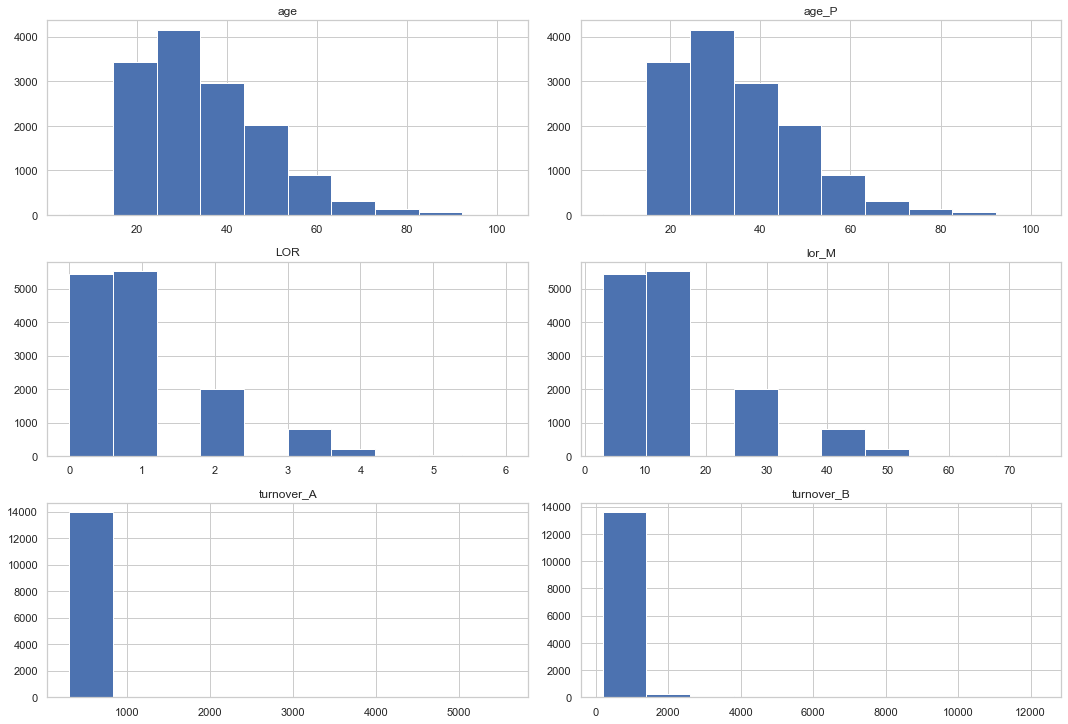

In [12]:
#Set plot parameters
plt.rcParams.update({'font.size': 12,'figure.figsize':(15,20)}) 

#Ignore warnings
np.warnings.filterwarnings('ignore')

#Use an index to identify the spot of the subplot
j=1

#For each numerical column 
for k in col_num :   
    plt.subplot(6,2,j) 
    plt.hist(df[k])
    plt.title('%s' %k)
    j=j+1 

plt.tight_layout()

#Show results    
plt.show()

1) age has 86 unique values with a mode of 23, a median of 33, and a mean of 36.  The histogram is right-skewed. <br>
2) age_P has 86 unique values with a mode of 23, a median of 33, and a mean of 36.  This is the same as age.  The histogram is right-skewed. <br>
3) LOR has 7 unique values with a mode of 1, a median of 1, and a mean of 0.93.<br>
4) lor_M has 7 unique values with a mode of 15, a median of 15, and a mean of 14.12. This is the same as LOR just on a monthly scale instead of yearly.<br>
5) turnover_A has 11,008 unique values with no unique mode, a median of 367.89, and a mean of 379.16.<br>
6) turnover_B has 11,008 unique values with no unique mode, a median of 237.66, and a mean of 328.63.<br>

Check the boxplots for outliers.

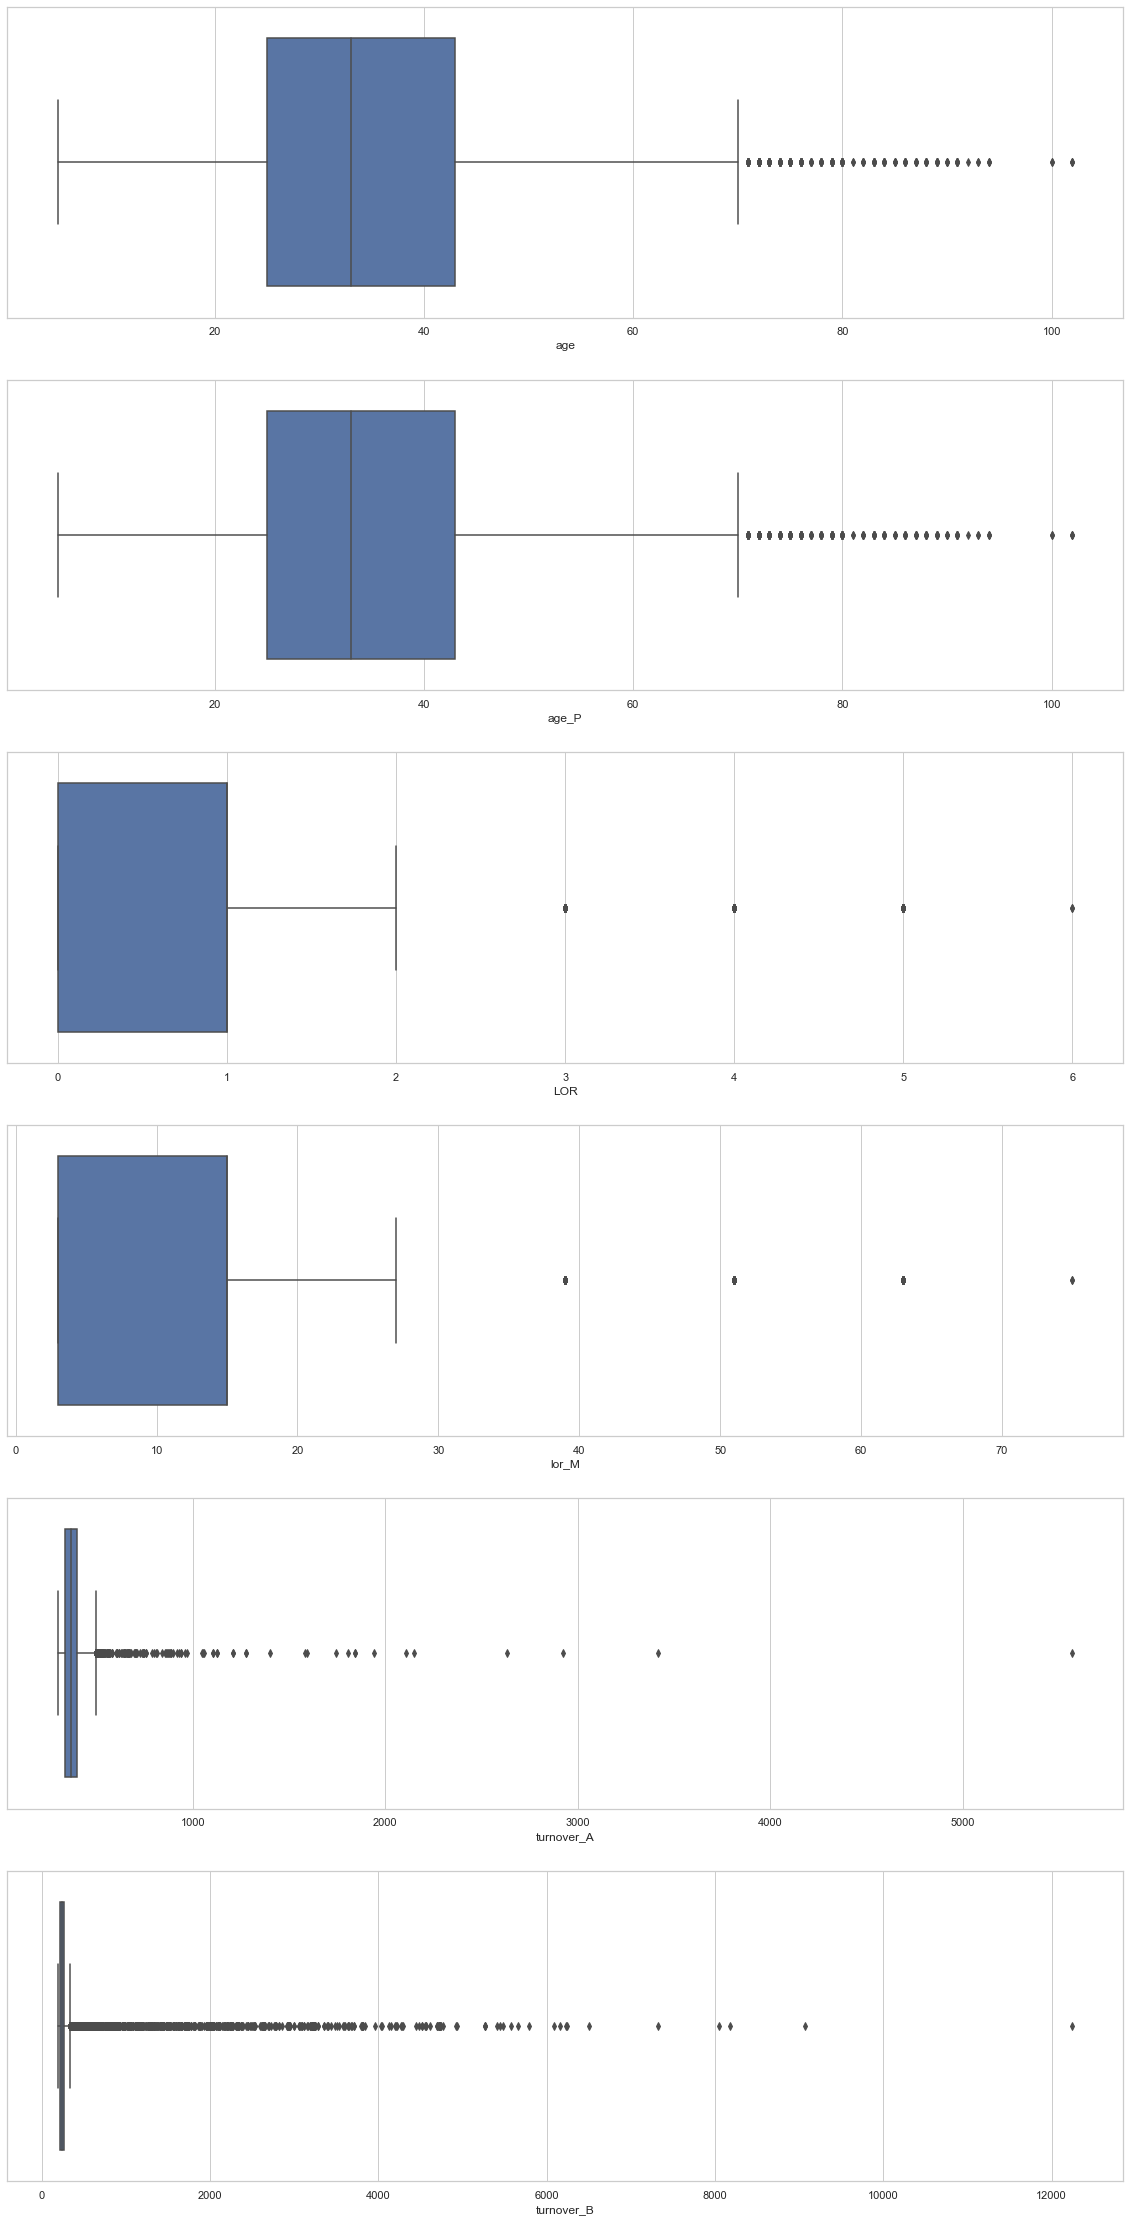

In [13]:
#Define a figure to which we will add a boxplot for each of our attributes
plt.figure(figsize=(20,40))

#Ignore warnings
np.warnings.filterwarnings('ignore')

#Use an index to identify the spot of the subplot
j=1

#For each numeric variable display a boxplot
for k in col_num :    
    plt.subplot(6,1,j) 
    sns.boxplot(x=k, data=df);
    j=j+1

#Show results    
plt.show()

We see again that age and age_P are nearly identical.<br>
LOR and lor_M are identical just with a different scale.<br>
Turnover A and Turnover B have a lot of outliers.

Let's look at the numeric attributes vs the TARGET.

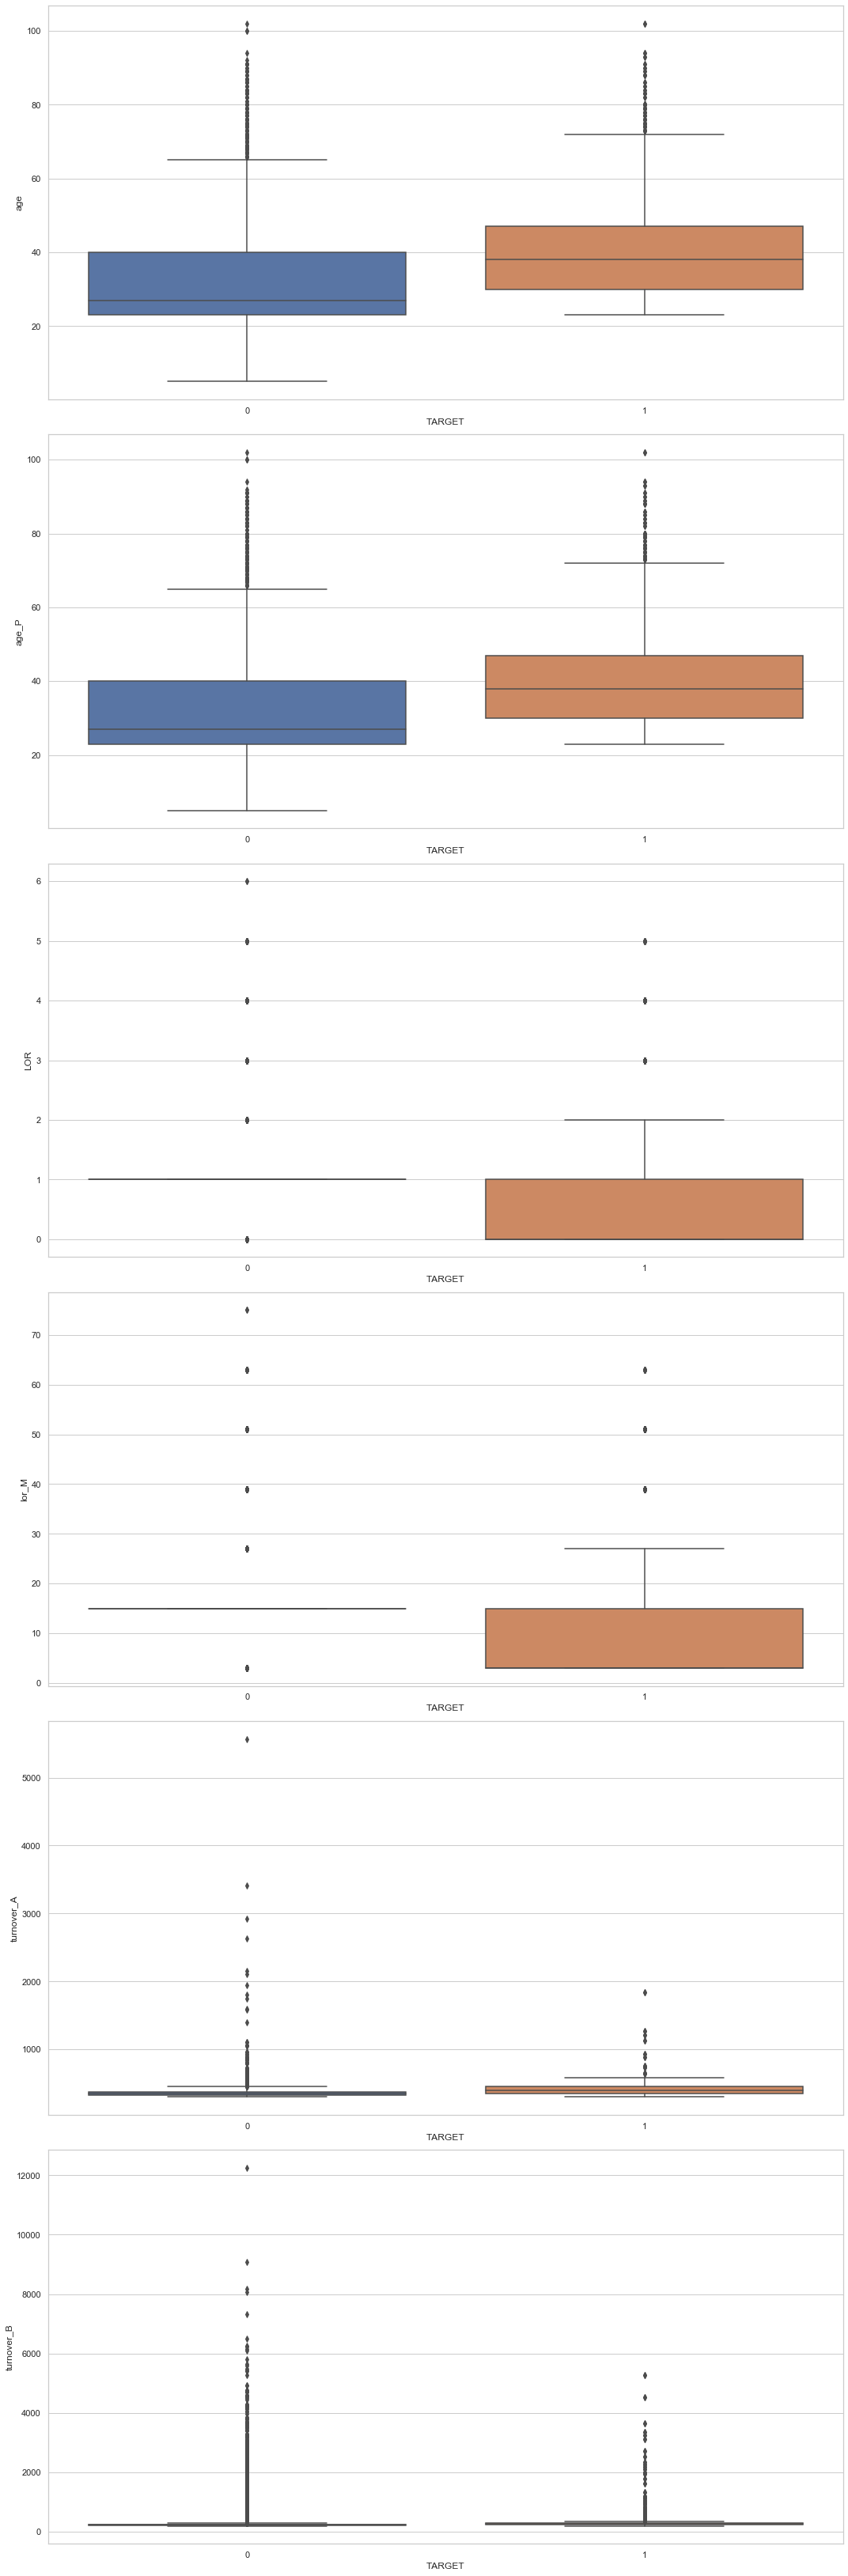

In [14]:
#Set plot parameters
plt.rcParams.update({'font.size': 10,'figure.figsize':(15,75)}) 

#Use an index to identify the spot of the subplot
j=1

#For each categorical attribute
for k in df[col_num].columns.to_list():    
    plt.subplot(10,1,j) 
    sns.boxplot(data=df, y=k, x='TARGET')
    j=j+1

plt.tight_layout()

#Show results    
plt.show()

We do not expect age, age_P, LOR, or lor_M to as predictive of TARGET as turnover_A and turnover_B.

Check the correlation matrix to see if any of the numeric values are highly correlated.

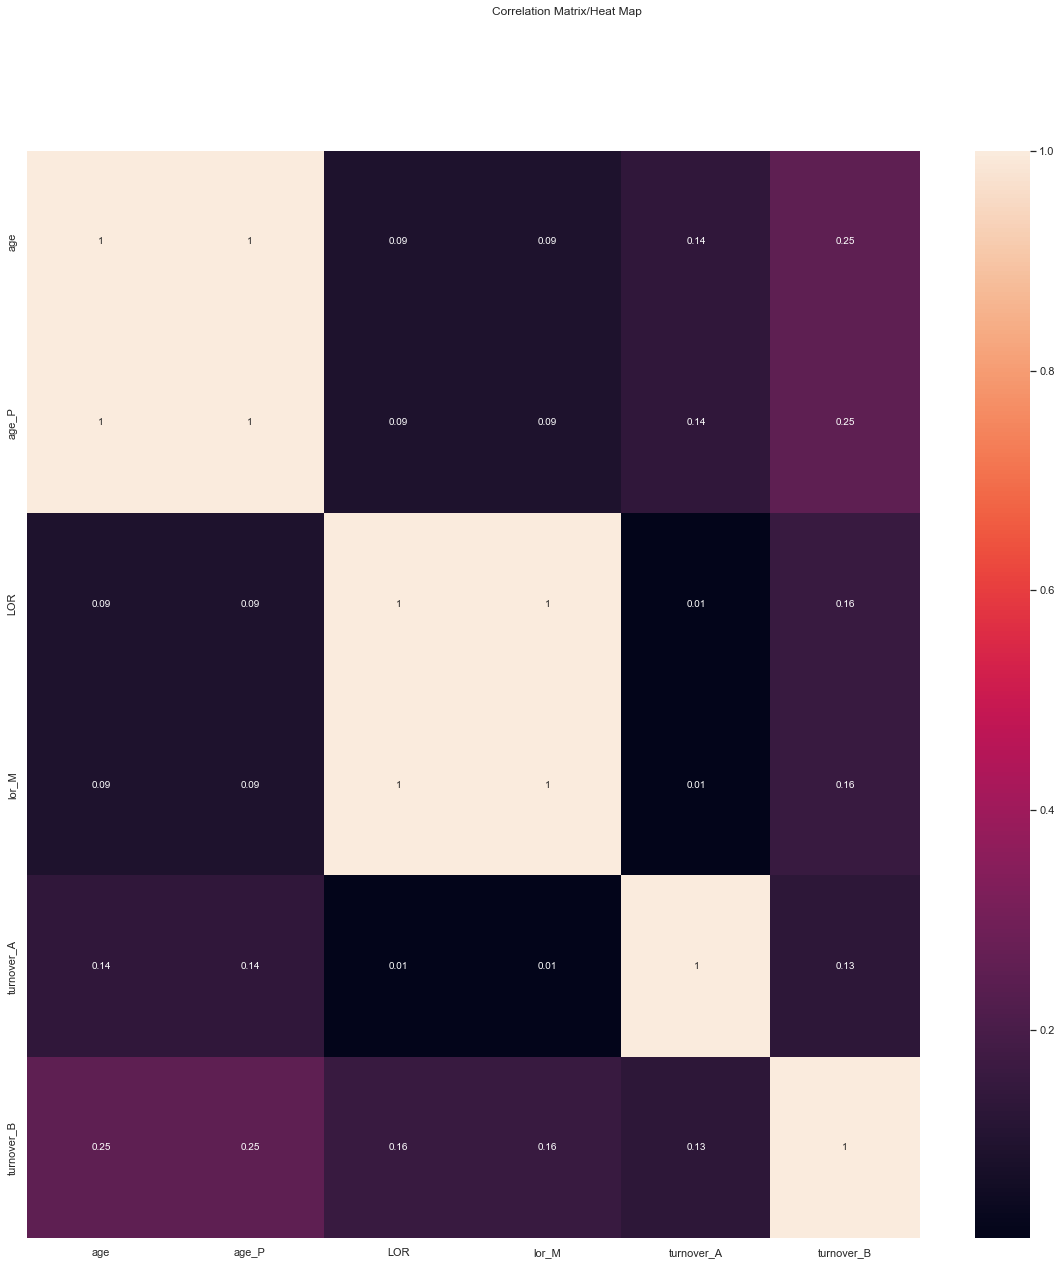

In [15]:
#Graph heat map for correlation
corr_num=df[col_num].corr()
fig = plt.figure(figsize=(20, 20))
sns.heatmap(corr_num, annot=True);
fig.suptitle('Correlation Matrix/Heat Map') 
plt.show()

age and age_P are highly correlated.<br>
LOR and lor_M are highly correlated.<br>
This is what we expected after seeing our results for the histograms and boxplots.

Plot a bar chart for each of the categorical attributes.

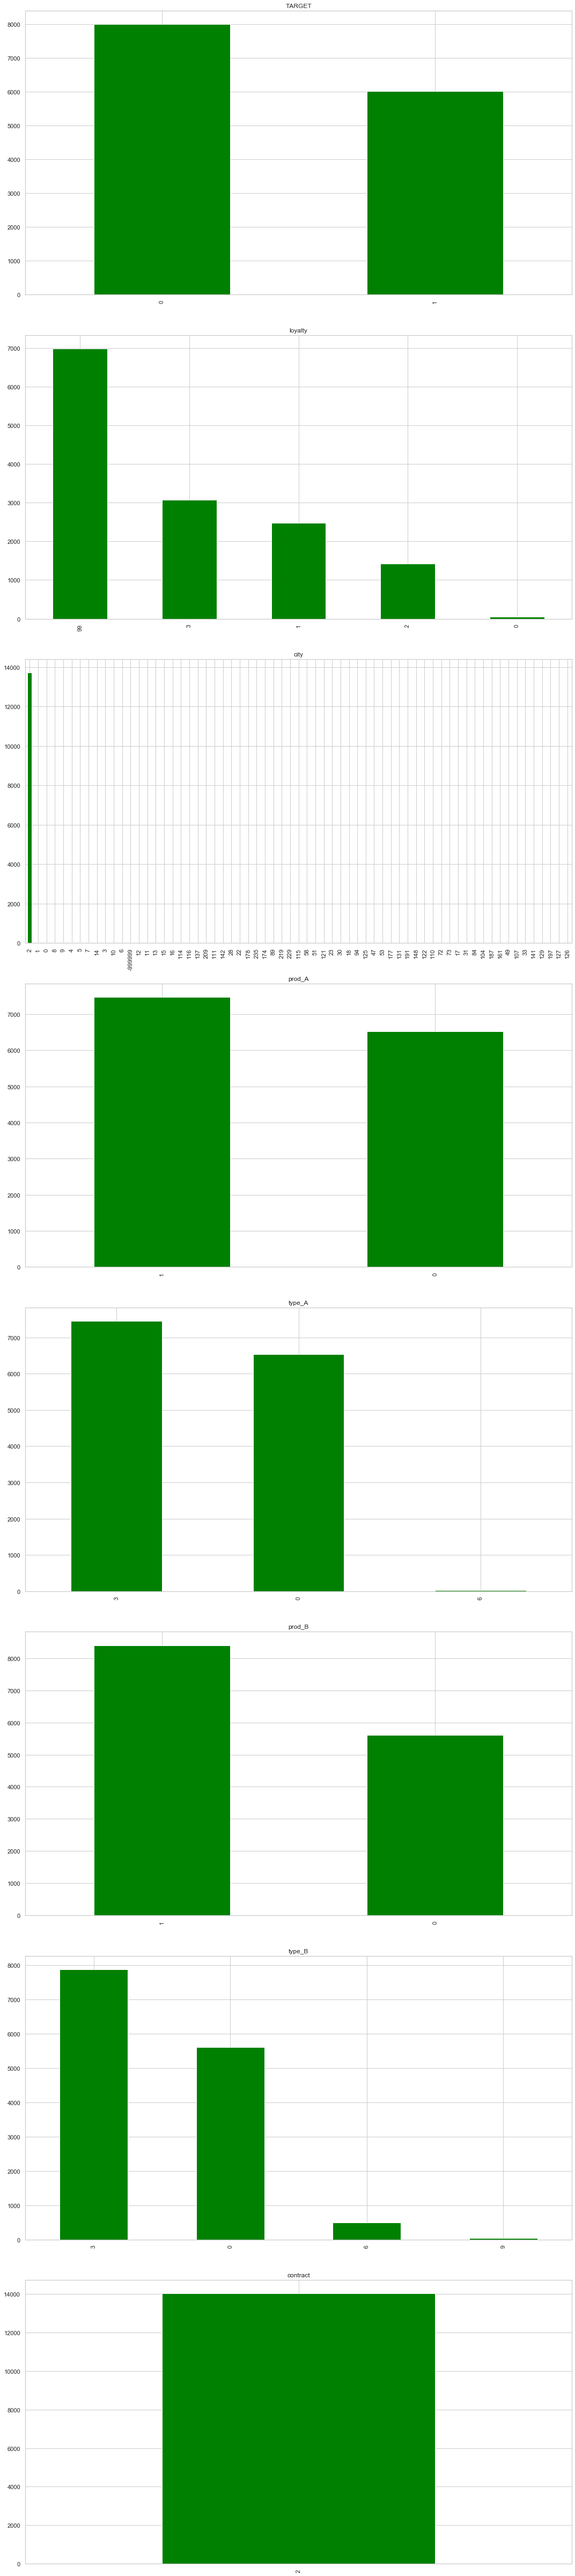

In [16]:
#Use an index to identify the spot of the subplot
j=1

#For each categorical column 
for k in col_cat :   
    plt.subplot(9,1,j) 
    df[k].value_counts().plot(kind='bar', color='green');
    plt.title('%s' %k)
    
#Add 1 to go to the next subplot space
    j=j+1 

plt.tight_layout()

#Show results    
plt.show()

1) The most common observation for TARGET (*attribute we intend to predict*) is N with ~57% No, ~43% Yes. <br>

2) The most common observation for loyalty is 99 which means unclassified.<br>
'99', the unclassified value, ~46% of the values<br>
'3' = ~24% of the values<br>
'2' = ~11% of the values<br>
'1' = ~18% of the values<br>
'0' = ~1% of the values<br>

3) The most common observation for city is 2.  ~97.8% of values are of one particular city, a highly imbalanced class.<br>

4) The most common observation for prod_A is 1 which means that product A was purchased. ~42% of values have bought product A, ~58% of values have not bought product A.<br>

5) The most common observation for type_A is 3. ~58% of values are '3', ~42% of values are '0', ~0.2% of values are '6'.<br>

6) The most common observation for prod_B is 1 which means that product B was purchased. ~65% of values have bought product B, ~35% of values have not bought product B.<br>

7) The most common observation for type_B is 3. ~61% of values are '3', ~35% of values are '0', ~4% of values are '6', and ~0.3% of values are '9'.<br>

8) Contract only contains the number 2.  We will drop this column from the data set since it is not predictive.<br>

Let's take a closer look at city.

In [17]:
print(df['city'].value_counts())

2      13720
1         28
0         26
8         21
9         20
       ...  
141        1
129        1
197        1
127        1
126        1
Name: city, Length: 65, dtype: int64


13,720 of the 14,016 rows have a city value of 2.  This is about 97.89% of our data.  We will drop the city column since it will not be predictive.

In [18]:
#Check for duplicates
df[df.duplicated()]

,TARGET,loyalty,age,city,LOR,prod_A,type_A,type_B,prod_B,turnover_A,turnover_B,contract,age_P,lor_M
10,1,99,23,2,0,0,0,0,0,344.970885,200.509497,2,23,3
18,1,99,23,2,0,0,0,0,0,391.468245,201.137168,2,23,3
22,1,99,23,2,0,0,0,0,0,482.088212,201.423182,2,23,3
49,1,99,23,2,0,0,0,0,0,312.372399,203.346010,2,23,3
52,1,99,23,2,0,0,0,0,0,391.856106,203.514047,2,23,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13993,1,1,37,2,5,0,0,3,1,321.194326,287.000973,2,37,63
13997,1,1,42,2,5,0,0,3,1,381.976630,301.201941,2,42,63
14000,1,1,46,4,5,1,3,6,1,487.749644,4520.203788,2,46,63
14004,1,1,50,2,5,1,3,6,1,455.904742,436.696355,2,50,63


In checking for duplicates, 3,008 duplicate rows were found.  We will need to delete the duplicates for an accurate analysis.

In [19]:
df = df.drop_duplicates()

#Check to make sure the duplicates were dropped
len(df)

11008

Our data set went from 14,016 rows to 11,008 rows after we removed the duplicates.  Now that the data is a bit cleaner, let's look at the mean of each attribute compared to the TARGET.

In [20]:
df.groupby('TARGET').mean()

,loyalty,age,city,LOR,prod_A,type_A,type_B,prod_B,turnover_A,turnover_B,contract,age_P,lor_M
TARGET,,,,,,,,,,,,,
0,39.791625,33.027125,-747.257125,1.081375,0.673000,2.025000,2.411625,0.74475,360.368141,371.263176,2.0,33.027125,15.976500
1,64.464428,39.680519,-662.669548,0.720080,0.348737,1.053191,1.263630,0.40625,404.152250,271.932769,2.0,39.680519,11.640957


We see that on average, people who purchase an additional insurance product are a bit older, length of relationship is shorter, they spent more on prod A and less on prod B.

For people who do not purchase an additional insurance product, on average they are a bit younger, the length of relationship is longer, they spend more on prod_B and less on prod_A.

<b> Distribution of categorical variables vs frequency of TARGET<b>

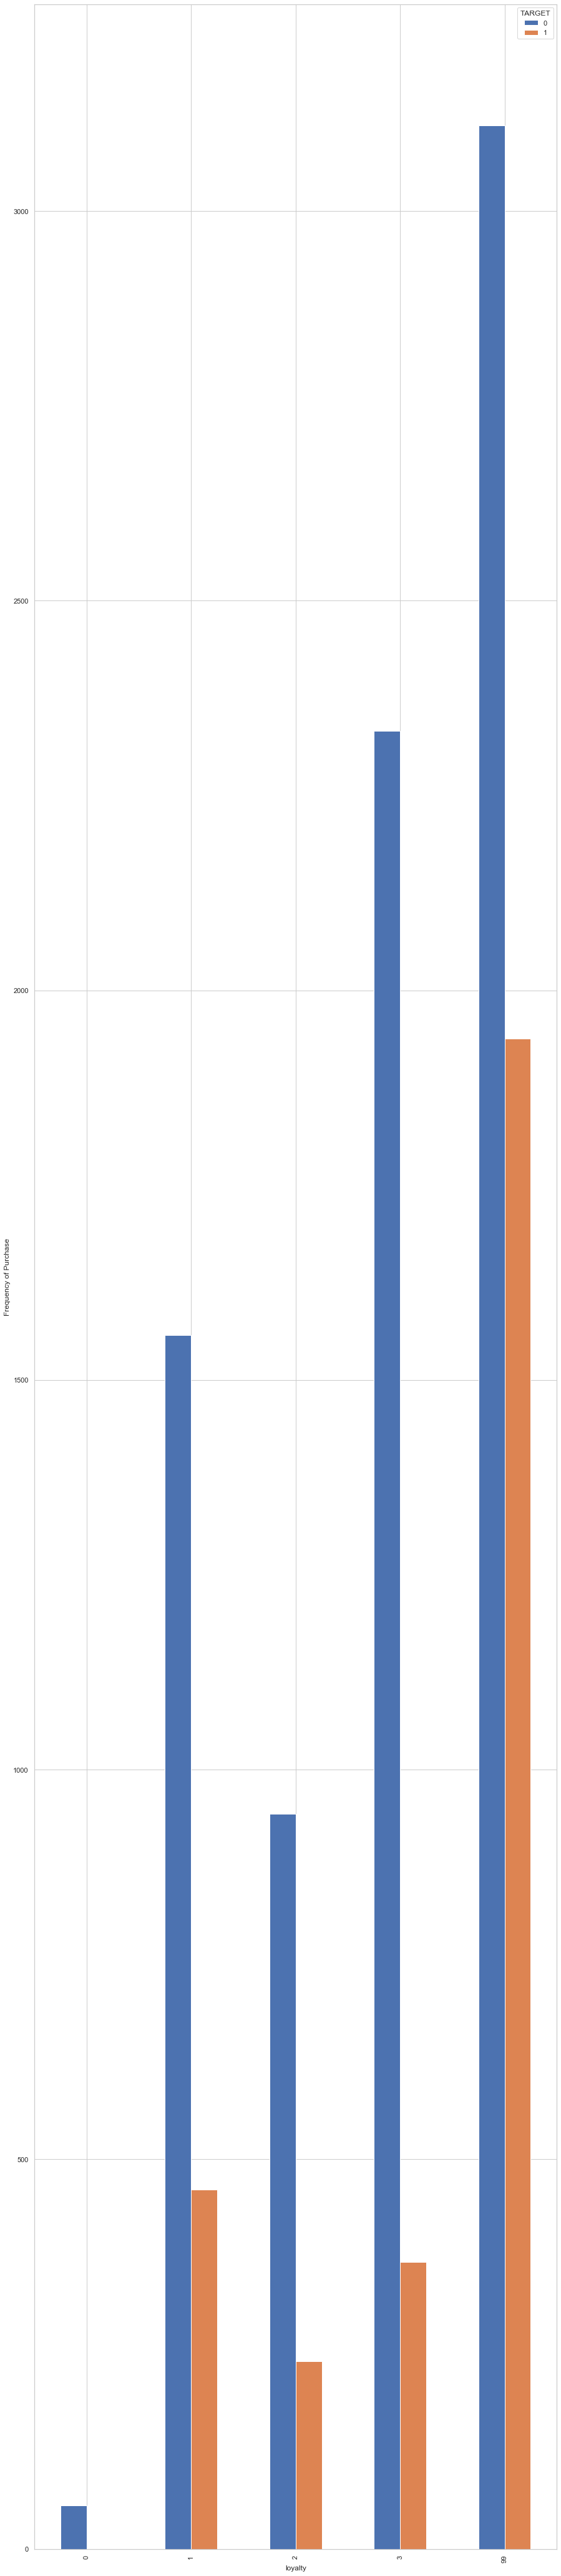

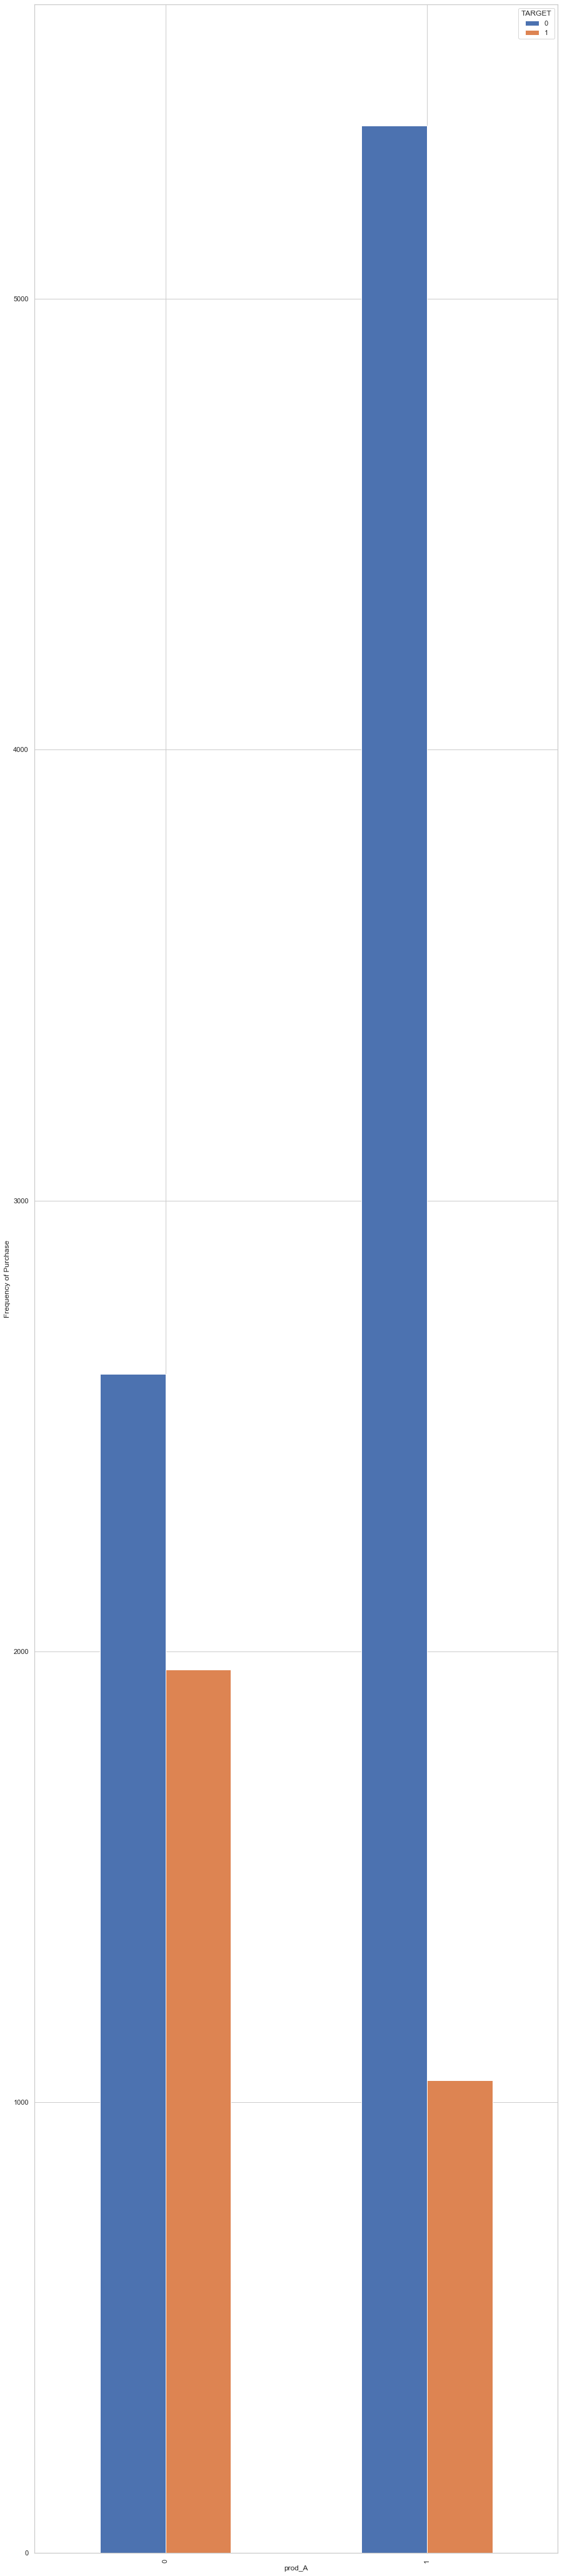

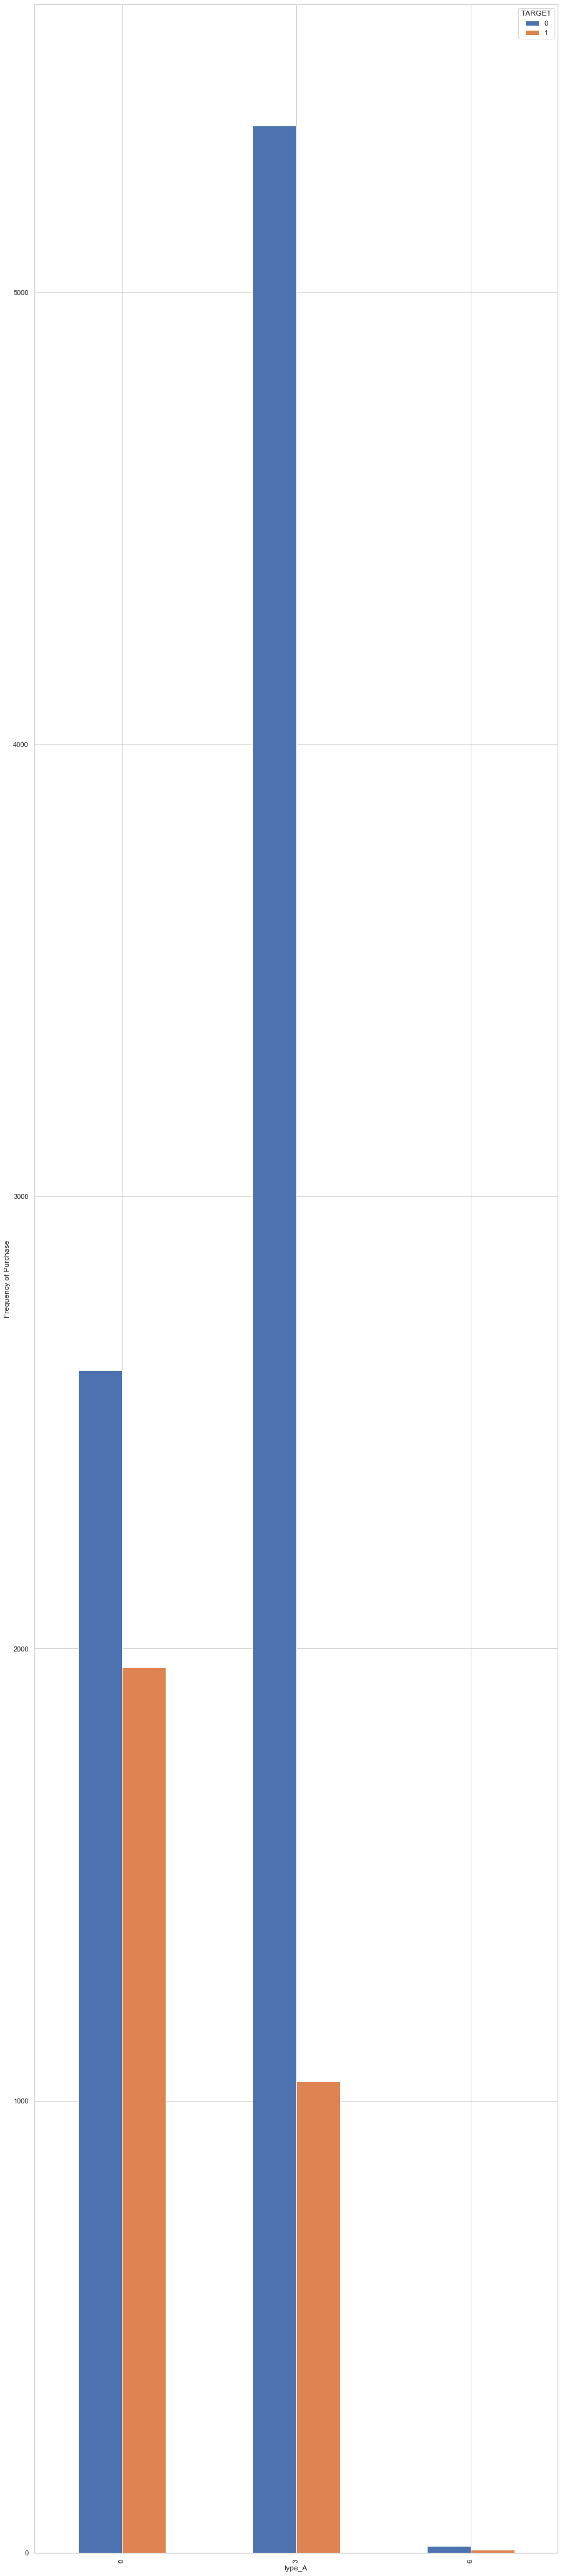

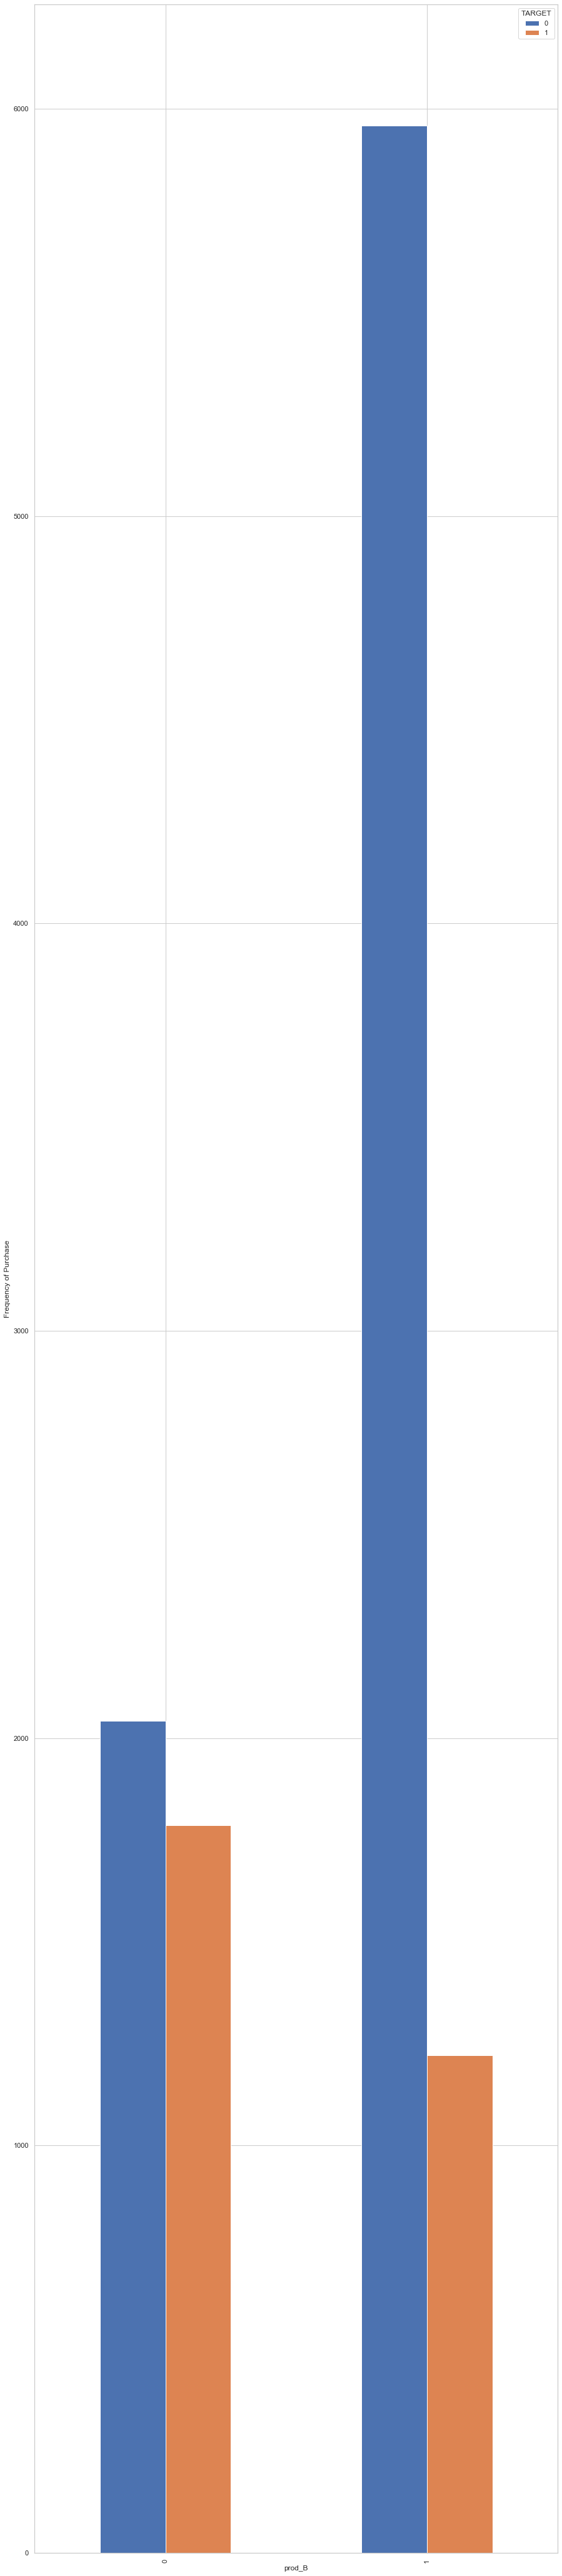

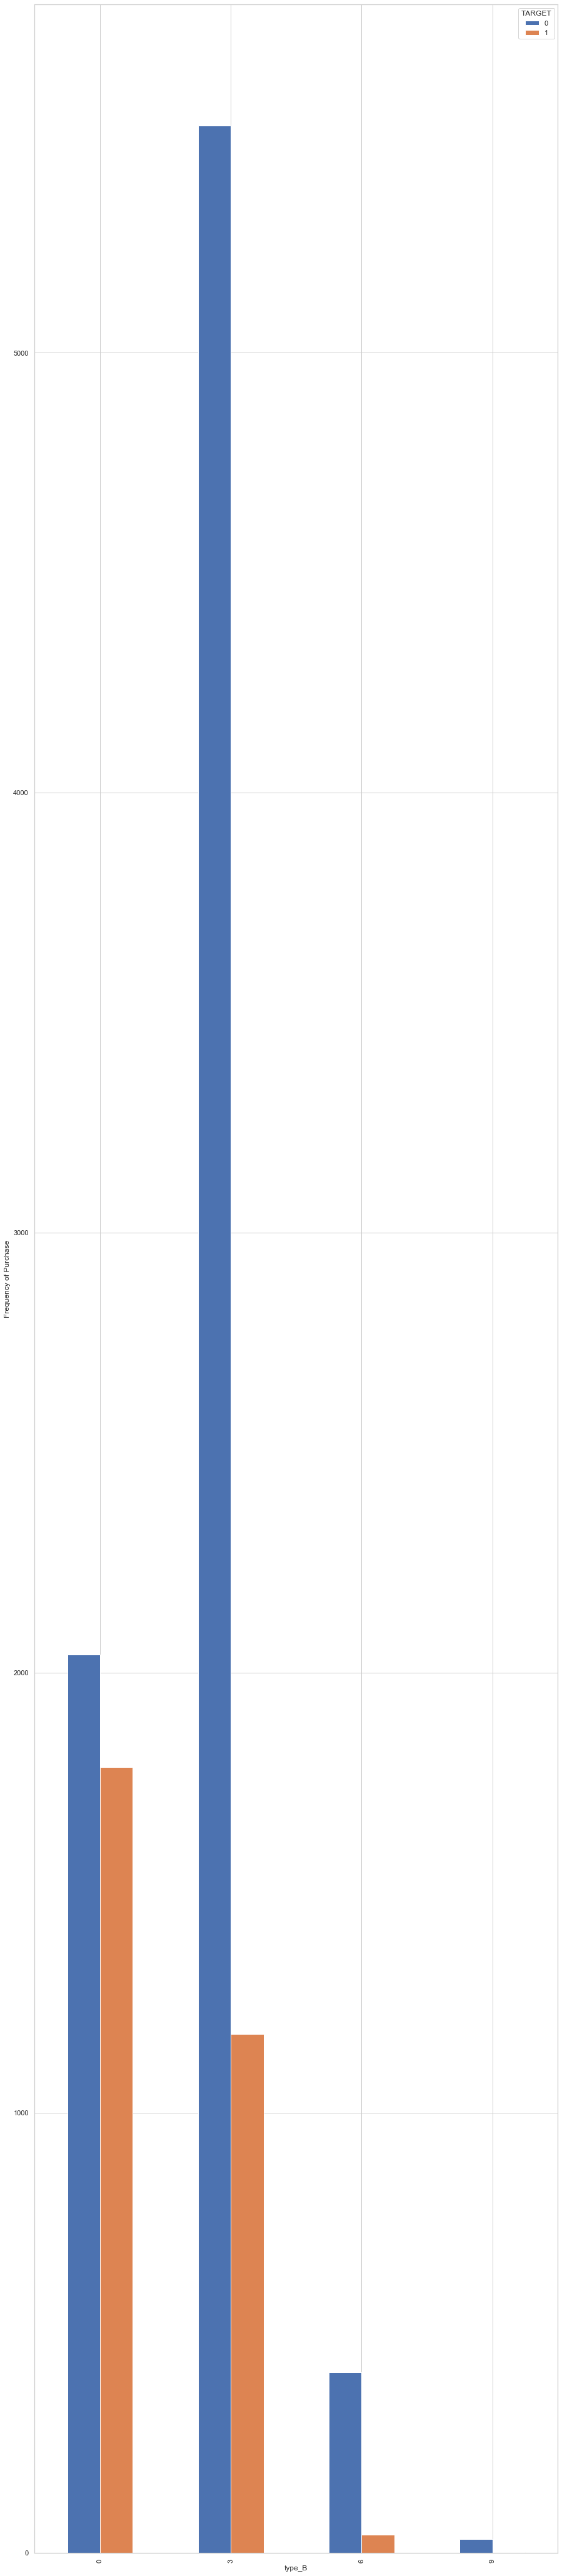

In [21]:
c = ['loyalty', 'prod_A', 'type_A', 'prod_B', 'type_B']

def crosstab_all(df,c):
    for k in c:
      pd.crosstab(df[k],df["TARGET"]).plot(kind='bar')
      plt.xlabel(k)
      plt.ylabel('Frequency of Purchase')

crosstab_all(df,c)

Very few people belong to the loyalty class of 0 and most are in the class 99 which is unclassified.<br>
Very few people belong to the type_A class of 6.<br>
Very few people belong to the type_B class 6 or 9.<br>

<h3><b>Data Preparation</b></h3>

Drop unnecessary columns from our data set.<br>
Drop the city column because 97.89% of its values are 2.<br>
Drop the contract column because it only contains the value 2. <br>
These numbers are meaningless to our analysis so we will removed them from our data set.<br>

Drop age_p as it is perfectly correlated with age.<br>
Drop lor_M as it is perfectly correlated with LOR.<br>

In [22]:
#Drop the city, contract, age_p, and lor_M columns.
df2 = df.drop(df.columns[[3, 11, 12, 13]], axis=1)

#View the data frame to ensure that the columns were removed
df2.head()

,TARGET,loyalty,age,LOR,prod_A,type_A,type_B,prod_B,turnover_A,turnover_B
0,0,99,11,0,0,0,0,0,357.339500,249.741496
1,0,99,13,0,0,0,0,0,351.427321,227.079688
2,0,99,14,0,0,0,0,0,345.609148,203.250249
3,0,99,22,0,0,0,0,0,398.448554,218.960897
4,0,99,22,0,0,0,0,0,355.744324,231.921720


Create dummy variables for categorial variables.

In [23]:
#Get dummies
categorical_dummy=pd.get_dummies(df.loyalty, drop_first = False)

#Rename columns
categorical_dummy.columns = ['loyalty_0', 'loyalty_1', 'loyalty_2', 'loyalty_3','loyalty_99']

#Display first 5 rows
categorical_dummy.head()

,loyalty_0,loyalty_1,loyalty_2,loyalty_3,loyalty_99
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1


In [24]:
#Get dummies
categorical_dummy2=pd.get_dummies(df.type_A, drop_first = False)

#Rename columns
categorical_dummy2.columns = ['typeA_0', 'typeA_3', 'typeA_6']

#Display first 5 rows
categorical_dummy2.head()

,typeA_0,typeA_3,typeA_6
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [25]:
#Get dummies
categorical_dummy3=pd.get_dummies(df.type_B, drop_first = False)

#Rename columns
categorical_dummy3.columns = ['typeB_0', 'typeB_3', 'typeB_6', 'typeB_9']

#Display first 5 rows
categorical_dummy3.head()

,typeB_0,typeB_3,typeB_6,typeB_9
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [26]:
#Concatenate the data frame with the dummies
df2 = pd.concat([df2, categorical_dummy, categorical_dummy2, categorical_dummy3], axis=1)

#Drop the columns that were converted to dummies.
#Dummy variable encoding always represents C categories with C-1 binary variables so also drop loyalty_0, typeA_0 and 
#typeB_0.
#Source: https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/
df3 = df2.drop(['loyalty', 'loyalty_0', 'type_A', 'typeA_6', 'type_B', 'typeB_9'], axis=1)

#Check results
df3.head()

,TARGET,age,LOR,prod_A,prod_B,turnover_A,turnover_B,loyalty_1,loyalty_2,loyalty_3,loyalty_99,typeA_0,typeA_3,typeB_0,typeB_3,typeB_6
0,0,11,0,0,0,357.339500,249.741496,0,0,0,1,1,0,1,0,0
1,0,13,0,0,0,351.427321,227.079688,0,0,0,1,1,0,1,0,0
2,0,14,0,0,0,345.609148,203.250249,0,0,0,1,1,0,1,0,0
3,0,22,0,0,0,398.448554,218.960897,0,0,0,1,1,0,1,0,0
4,0,22,0,0,0,355.744324,231.921720,0,0,0,1,1,0,1,0,0


<h3><b>Prepped Data Review</b></h3>

Since we deleted duplicates, deleted some columns, and added others. Let's look at our EDA again.

In [27]:
#Create lists of numerical and categorical attributes

col_cat2=['TARGET', 'loyalty_1', 'loyalty_2', 'loyalty_3','loyalty_99', 'prod_A', 'typeA_0', 
          'typeA_3', 'prod_B', 'typeB_0', 'typeB_3', 'typeB_6']

col_num2=['age', 'LOR', 'turnover_A', 'turnover_B']

print("# of numerical attributes:%s" %len(col_num2))
print("# of categorical attributes:%s" %len(col_cat2))

# of numerical attributes:4
# of categorical attributes:12


We went from 6 numerical attributes to 4 and 8 categorical attributes to 12.

Look at how the histograms to see how the numerical values have changed.

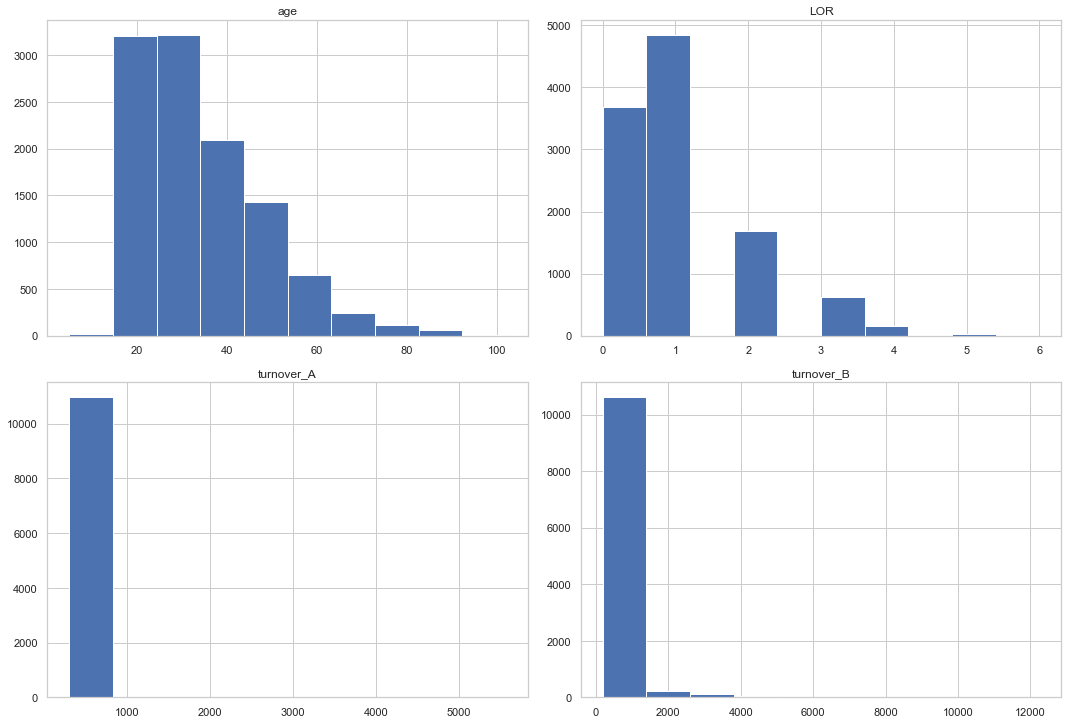

In [28]:
#Set plot parameters
plt.rcParams.update({'font.size': 12,'figure.figsize':(15,20)}) 

#Ignore warnings
np.warnings.filterwarnings('ignore')

#Use an index to identify the spot of the subplot
j=1

#For each numerical column 
for k in col_num2 :   
    plt.subplot(4,2,j) 
    plt.hist(df3[k])
    plt.title('%s' %k)
    j=j+1 

plt.tight_layout()

#Show results    
plt.show()

1) age has 86 unique values with a mode of 23, a median of 31, and a mean of 35.  The mode did not change but the median decreased from 33 to 31 and the mean decreased from 36 to 35.  The histogram is right-skewed.<br>
2) LOR has 7 unique values with a mode of 1, a median of 1, and a mean of 0.98.  The mode and median stayed the same, but the mean increased slightly from 0.93 to 0.98. <br>
3) turnover_A has 11,008 unique values with no unique mode, a median of 361.93, and a mean of 372.33. The median decreased from 367.89 to 361.93 and the mean decreased from 379.16 to 372.33.<br>
4) turnover_B has 11,008 unique values with no unique mode, a median of 235.08, and a mean of 344.12. The median decreased from 237.66 to 235.08 and the mean increased from 328.63 to 344.12.<br>

Let's look at the outliers of the numerical data to see how it's changed.

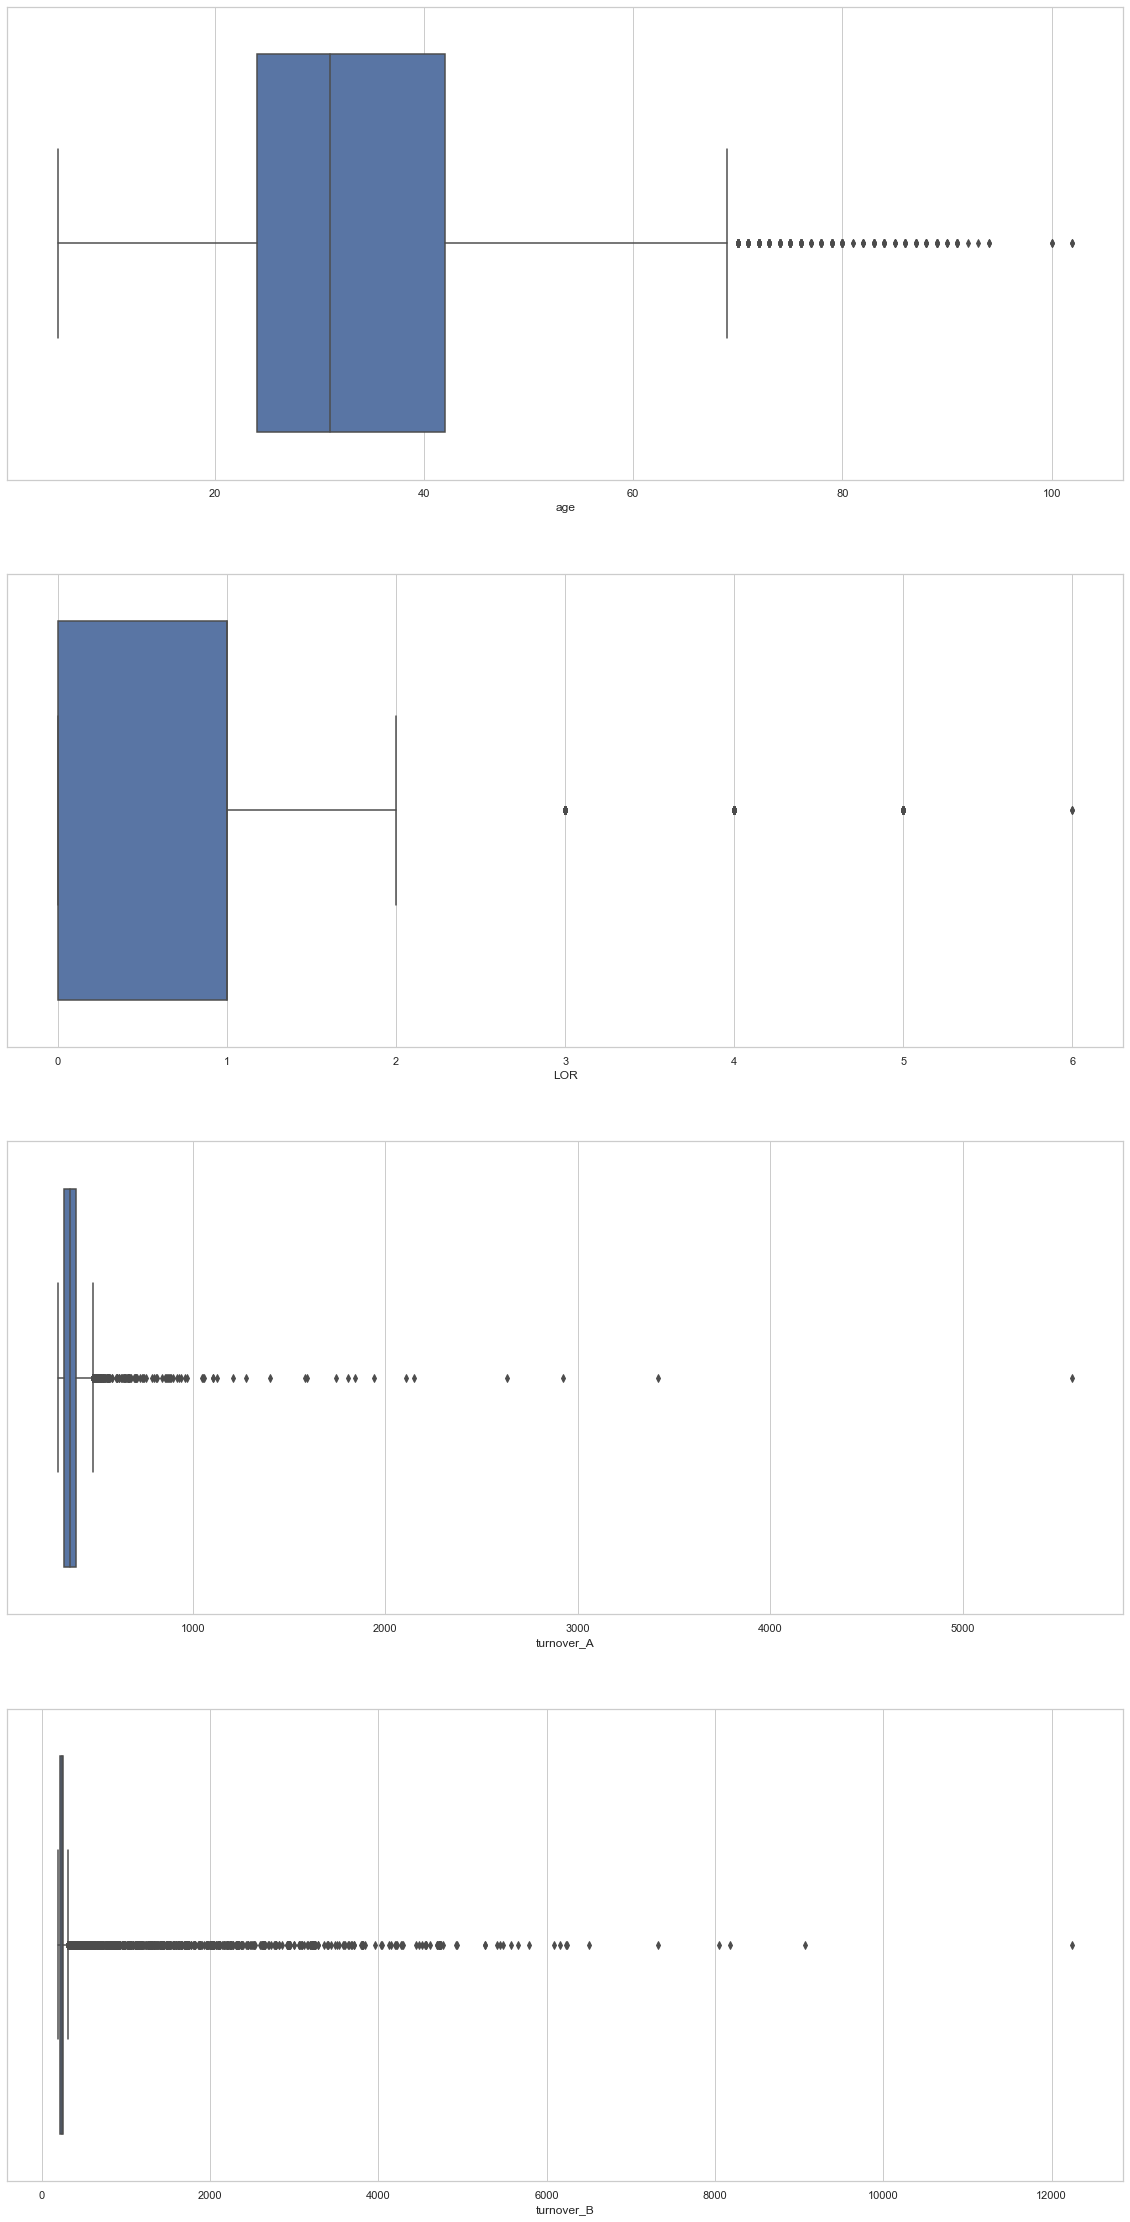

In [29]:
#Define a figure to which we will add a boxplot for each of our attributes
plt.figure(figsize=(20,40))

#Ignore warnings
np.warnings.filterwarnings('ignore')

#Use an index to identify the spot of the subplot
j=1

#For each numeric variable display a boxplot
for k in col_num2 :    
    plt.subplot(4,1,j) 
    sns.boxplot(x=k, data=df3);
    j=j+1

#Show results    
plt.show()

We have outliers with each of our variables, but it is the most extreme for turnover_A and turnover_B.

Let's see how our numeric variables have changes when compared to TARGET.

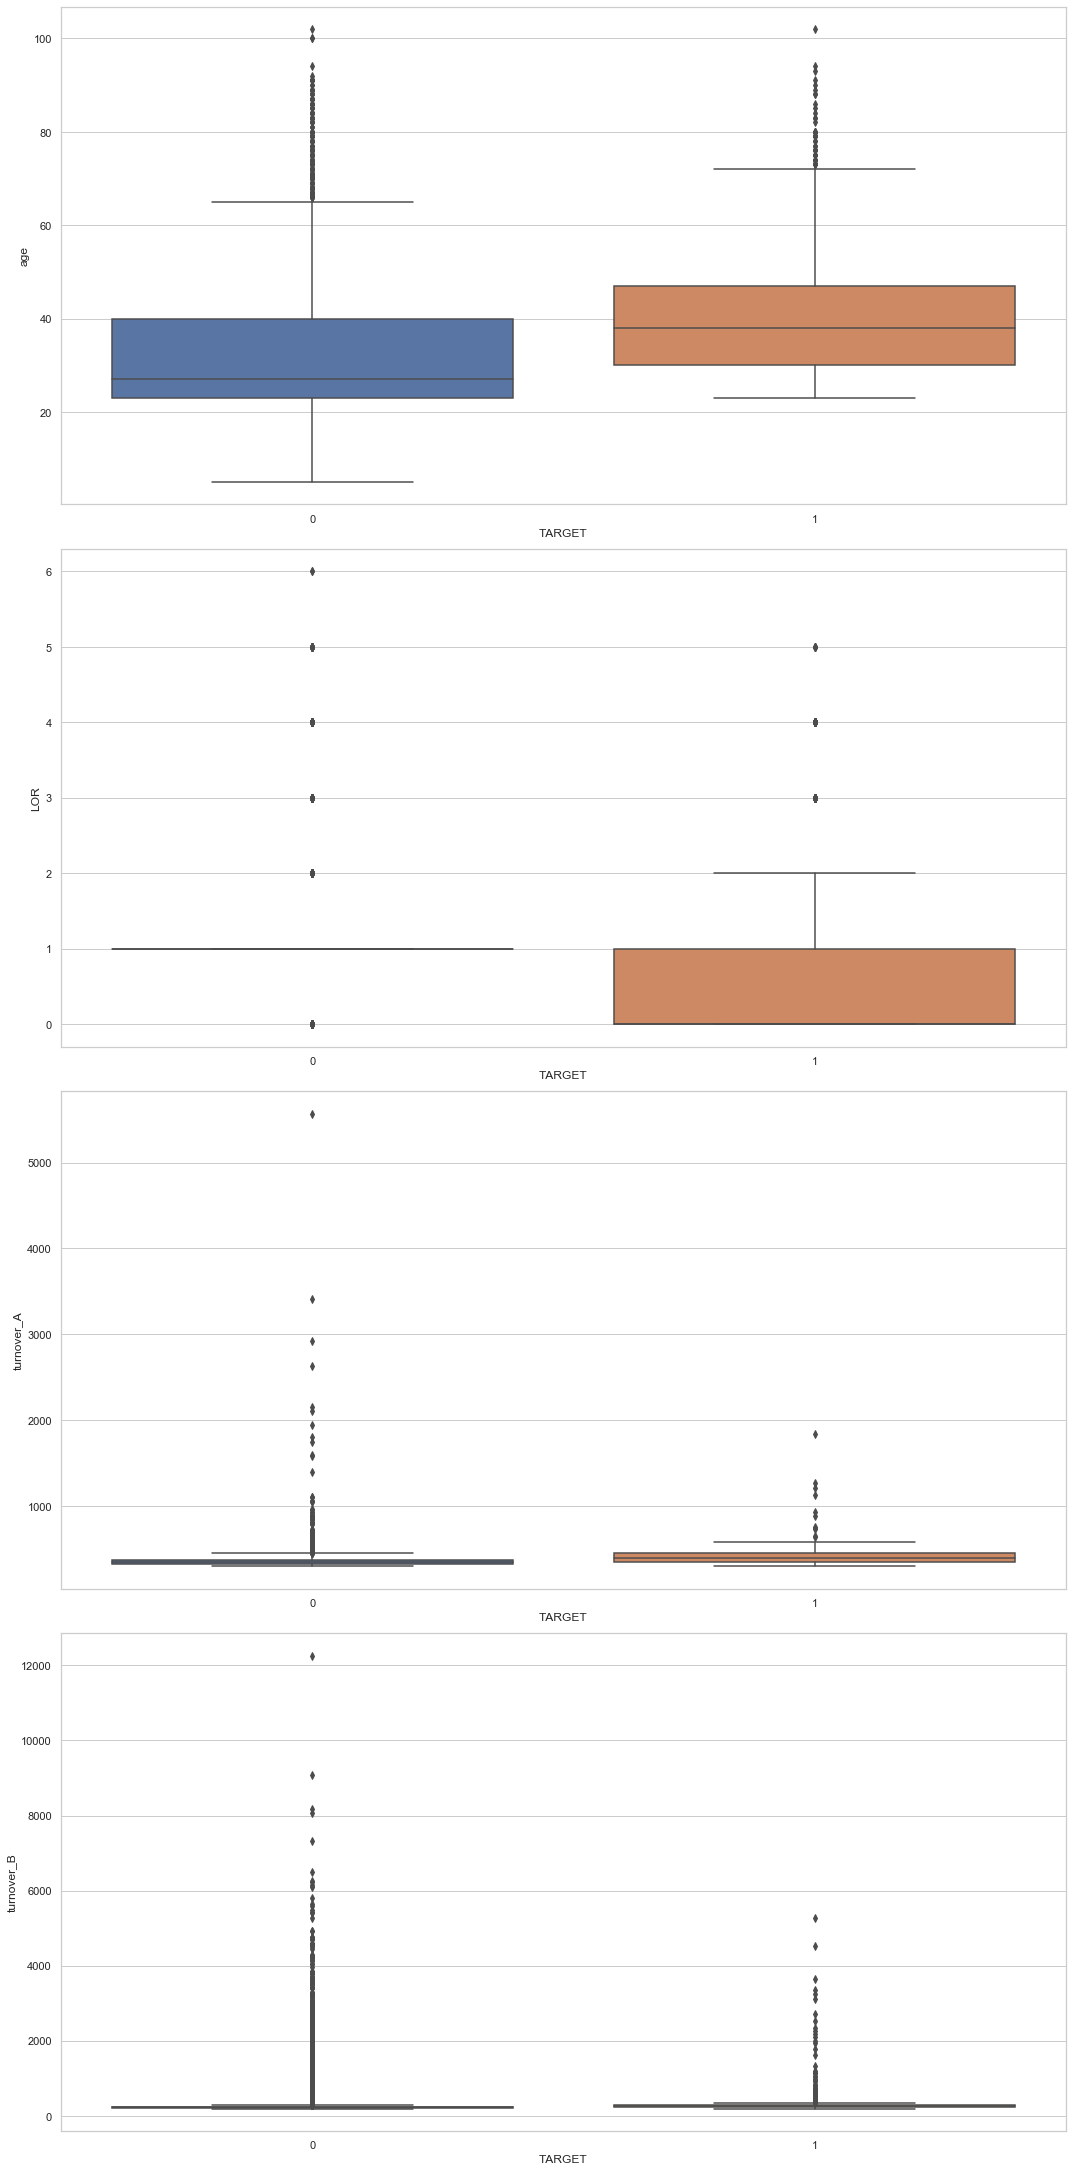

In [30]:
#Set plot parameters
plt.rcParams.update({'font.size': 10,'figure.figsize':(15,75)}) 

#Use an index to identify the spot of the subplot
j=1

#For each categorical attribute
for k in df3[col_num2].columns.to_list():    
    plt.subplot(10,1,j) 
    sns.boxplot(data=df3, y=k, x='TARGET')
    j=j+1

plt.tight_layout()

#Show results    
plt.show()

It seems that turnover_A and turnover_B will be more predictive than age and LOR.

Check for independence between features.

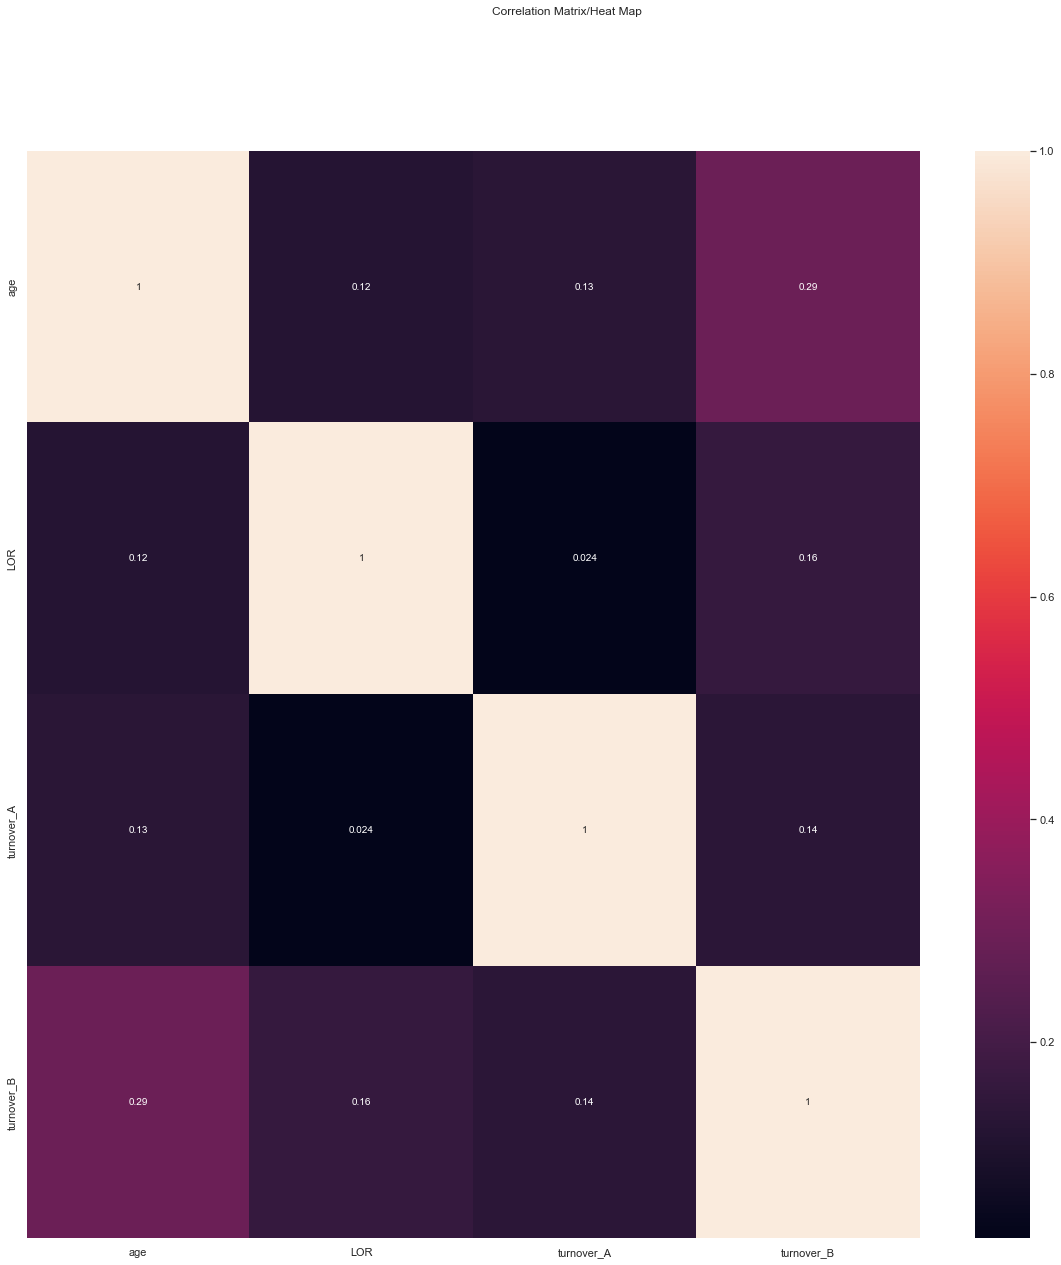

In [31]:
#Graph heat map for correlation
corr_num=df3[col_num2].corr()
fig = plt.figure(figsize=(20, 20))
sns.heatmap(corr_num, annot=True);
fig.suptitle('Correlation Matrix/Heat Map') 
plt.show()

The numeric variables show little correlation with each other.

Look at the box plots of the categorical variables to see how they have changed.

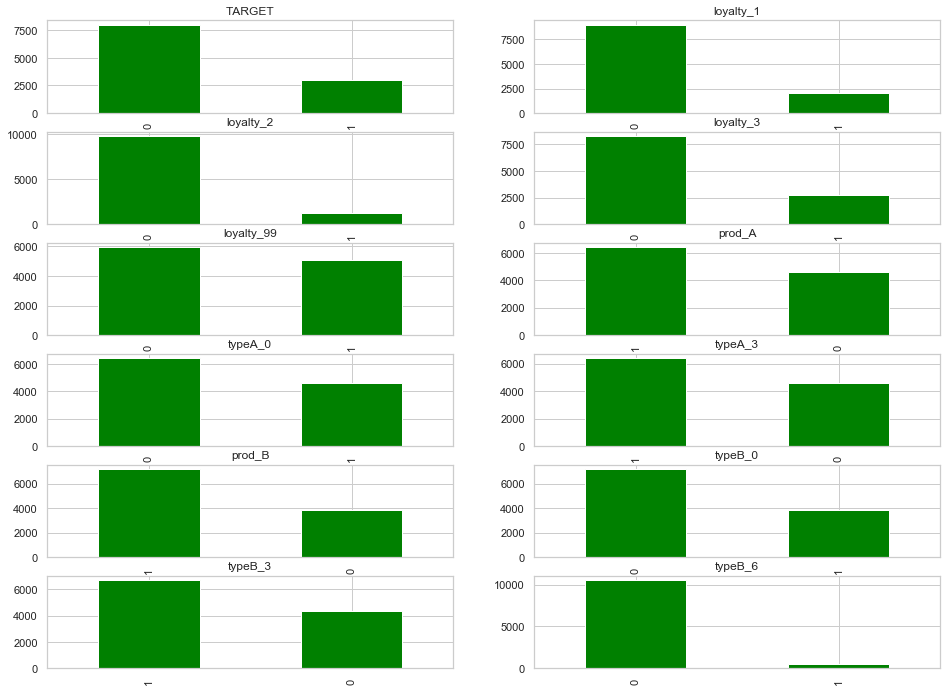

In [32]:
#Use an index to identify the spot of the subplot
j=1

#For each categorical column 
for k in col_cat2 :   
    plt.subplot(8,2,j) 
    df3[k].value_counts().plot(kind='bar', color='green');
    plt.title('%s' %k)
    
#Add 1 to go to the next subplot space
    j=j+1
    
plt.gcf().set_size_inches(16, 16)

#Show results    
plt.show()

**Percentage breakdown for categorical attributes is as follows:**

**TARGET:**
0 - ~73% of the values, 1 - ~27% of the values<br>
**loyalty_1:**
0 - ~82% of the values, 1 - ~18% of the values<br>
**loyalty_2:**
0 - ~89% of the values, 1 - ~11% of the values<br>
**loyalty_3:**
0 - ~75% of the values, 1 - ~25% of the values<br>
**loyalty_99:**
0 - ~54% of the values, 1 - ~46% of the values<br>
**prod_A:**
0 - ~42% of the values, 1 - ~58% of the values<br>
**typeA_0:**
0 - ~58% of the values, 1 - ~42% of the values<br>
**typeA_3:**
0 - ~42% of the values, 1 - ~58% of the values<br>
**prod_B:**
0 - ~35% of the values, 1 - ~65% of the values<br>
**typeB_0:**
0 - ~65% of the values, 1 - ~35% of the values<br>
**typeB_3:**
0 - ~39% of the values, 1 - ~61% of the values<br>
**typeB_6:**
0 - ~96% of the values, 1 - ~4% of the values<br>

Check to see how the distribution of categorical variables vs frequency of TARGET has changed.

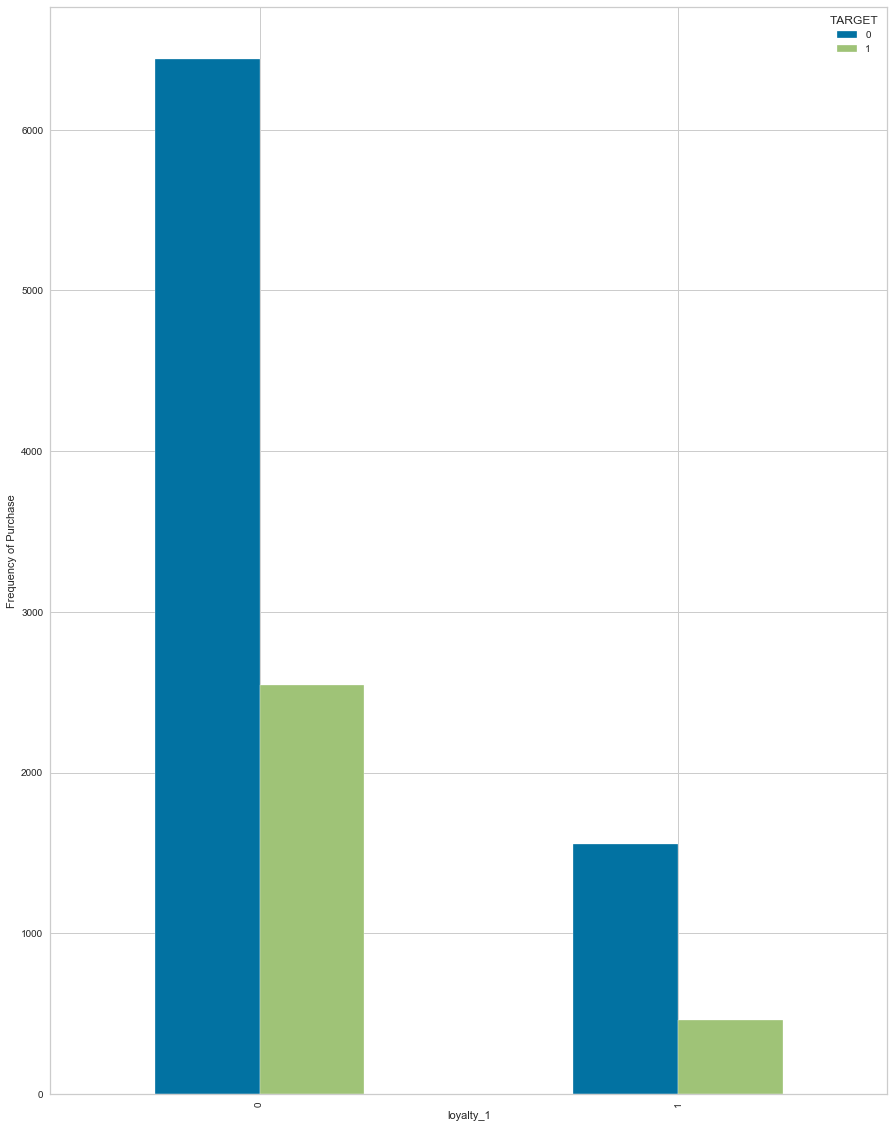

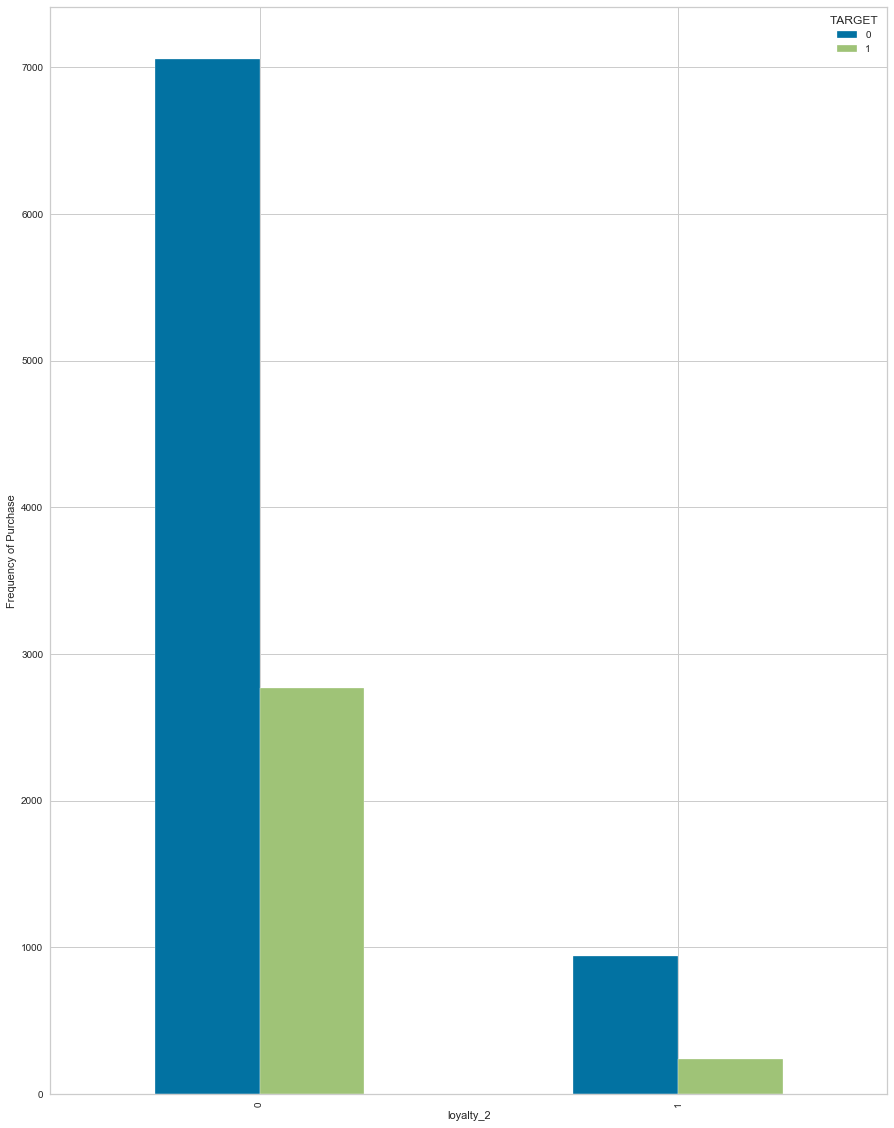

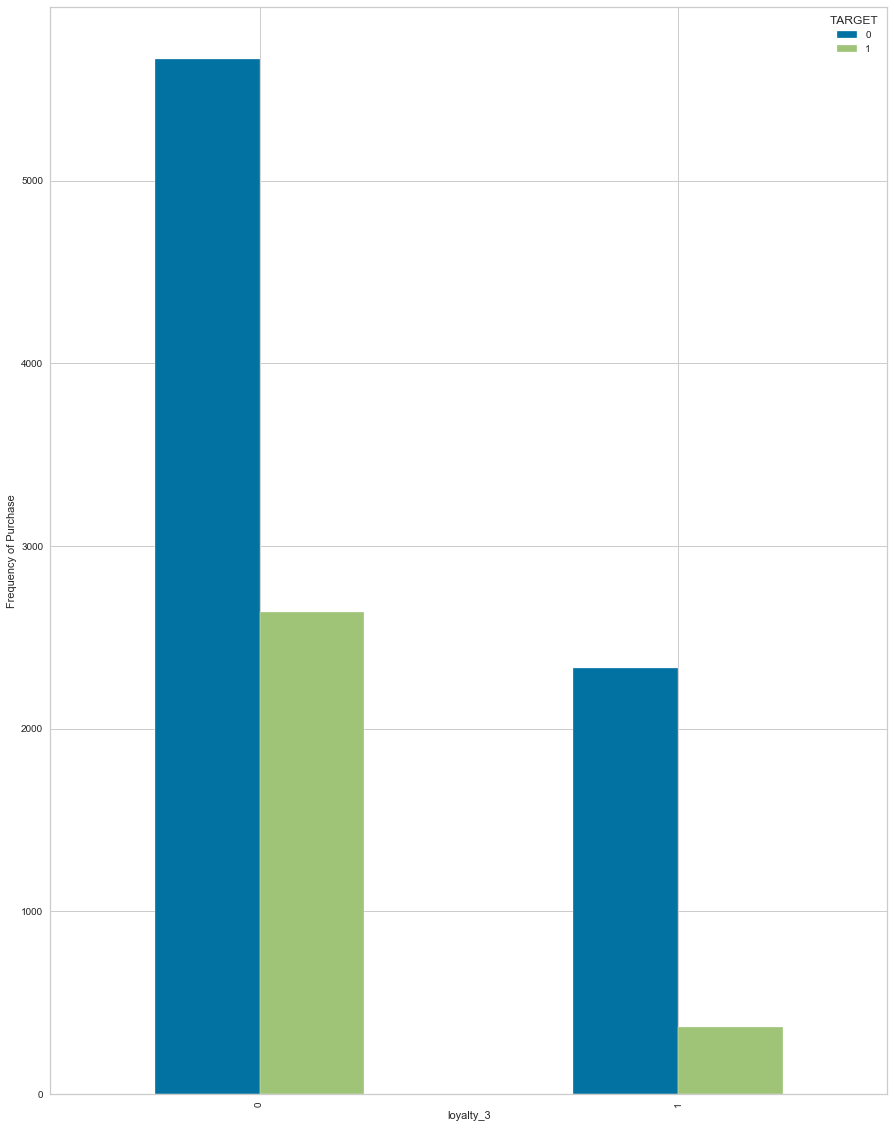

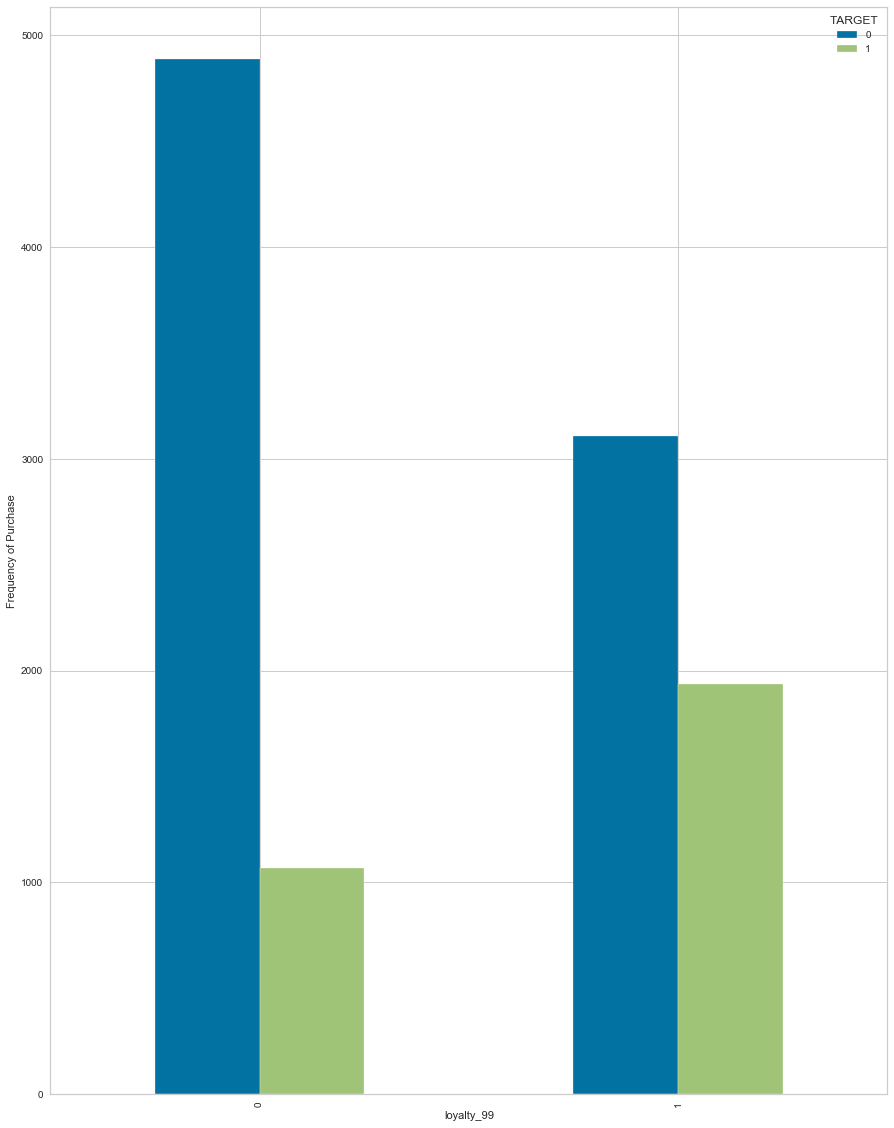

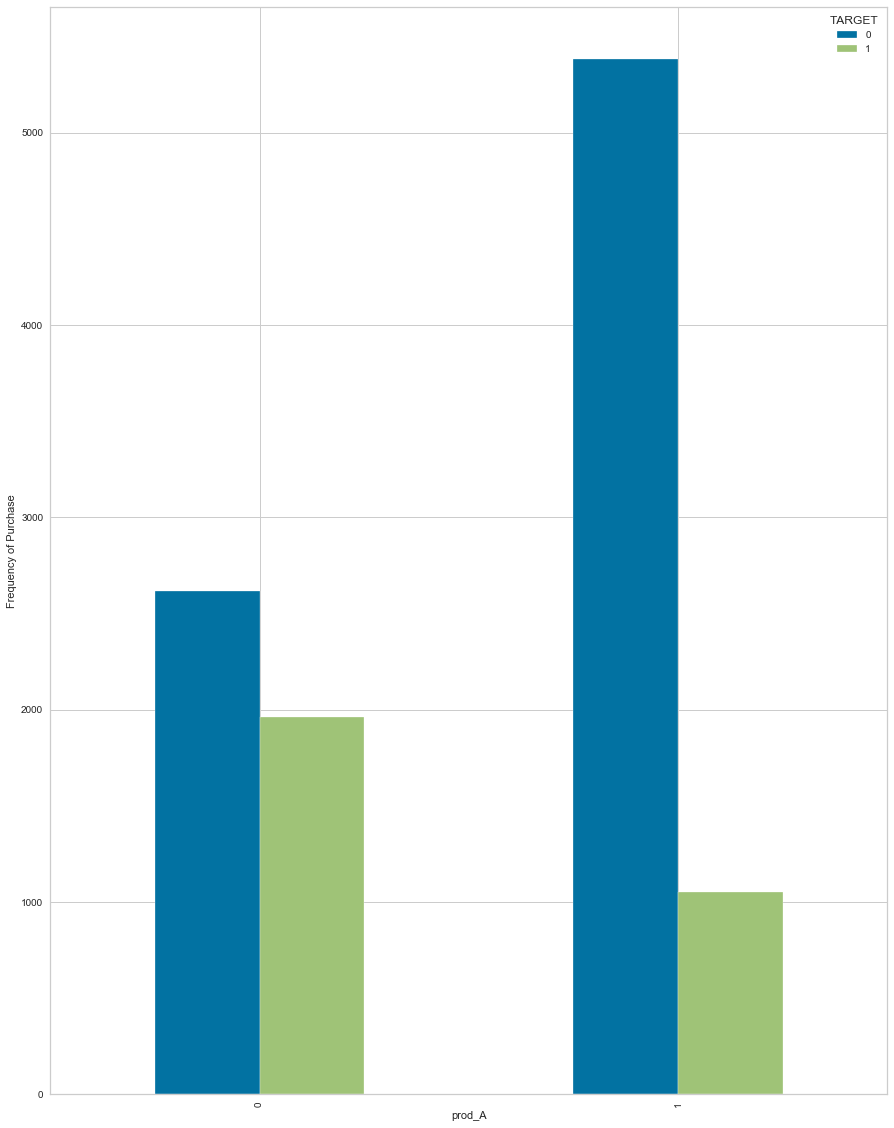

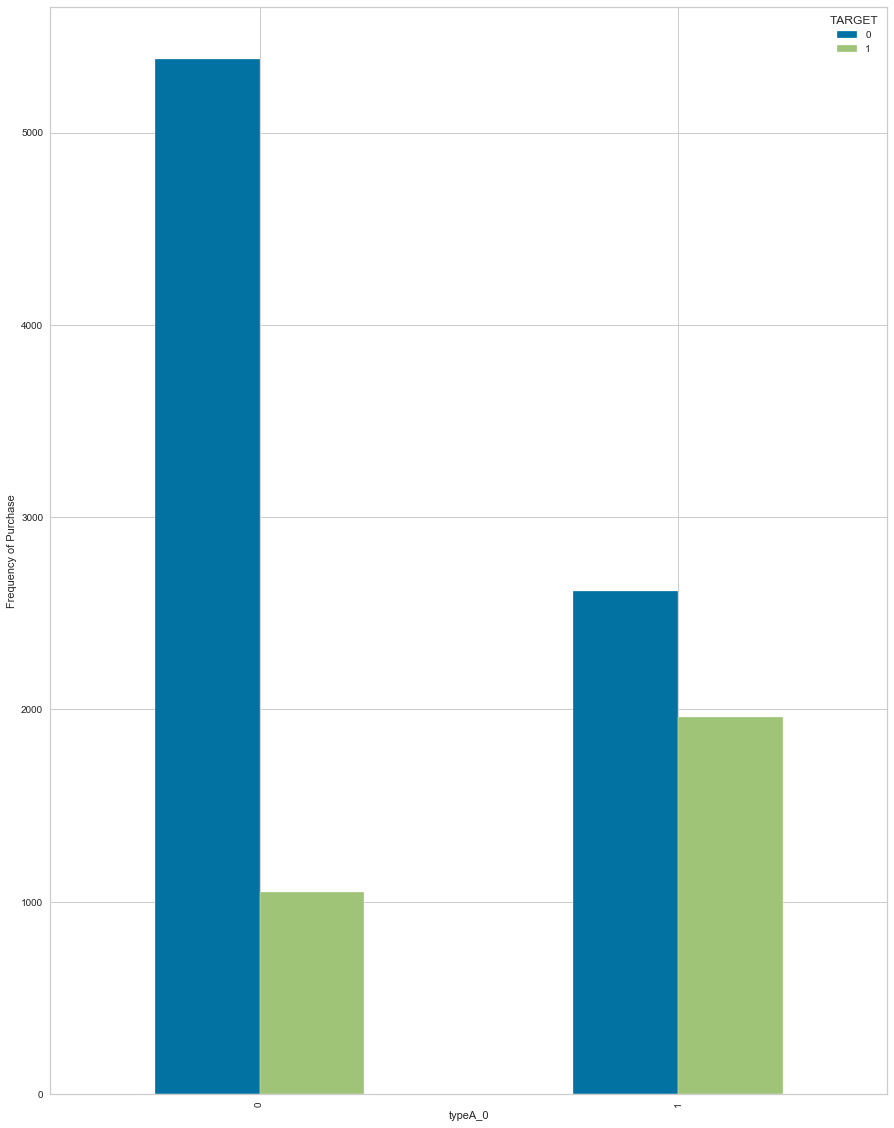

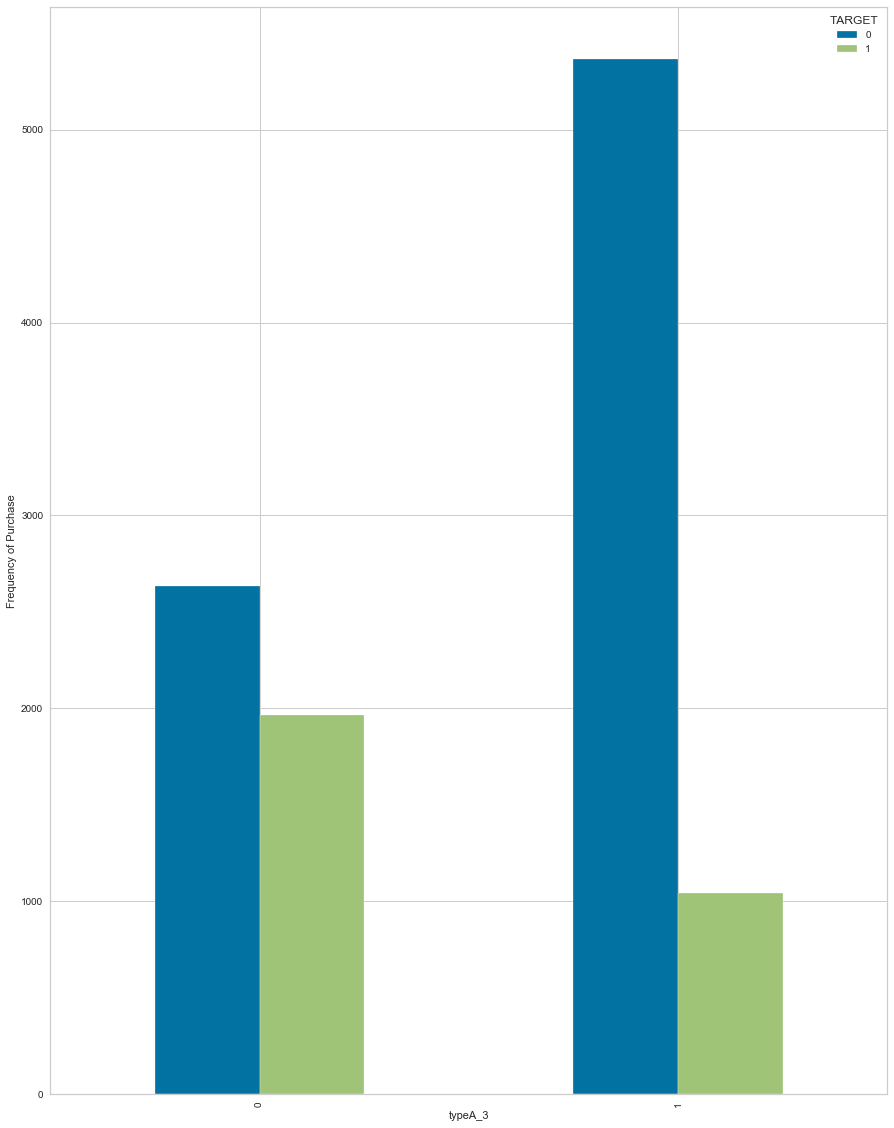

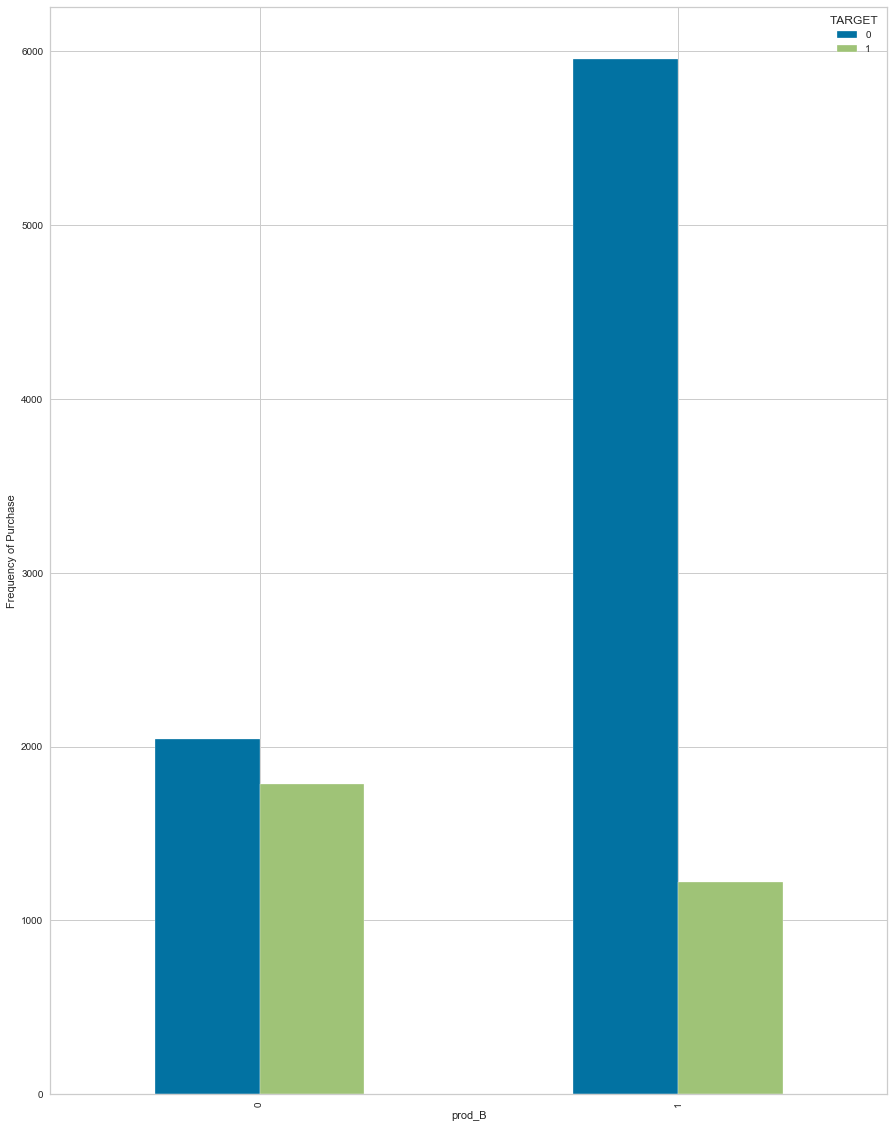

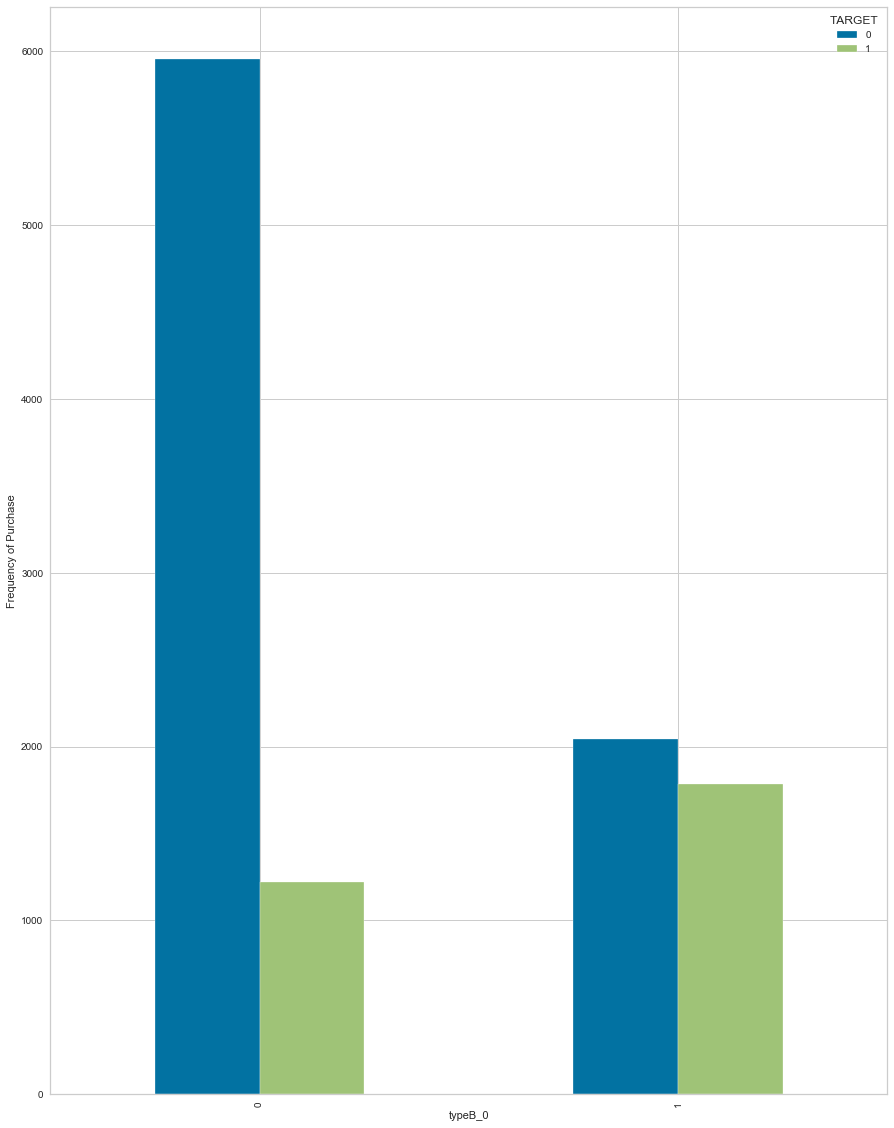

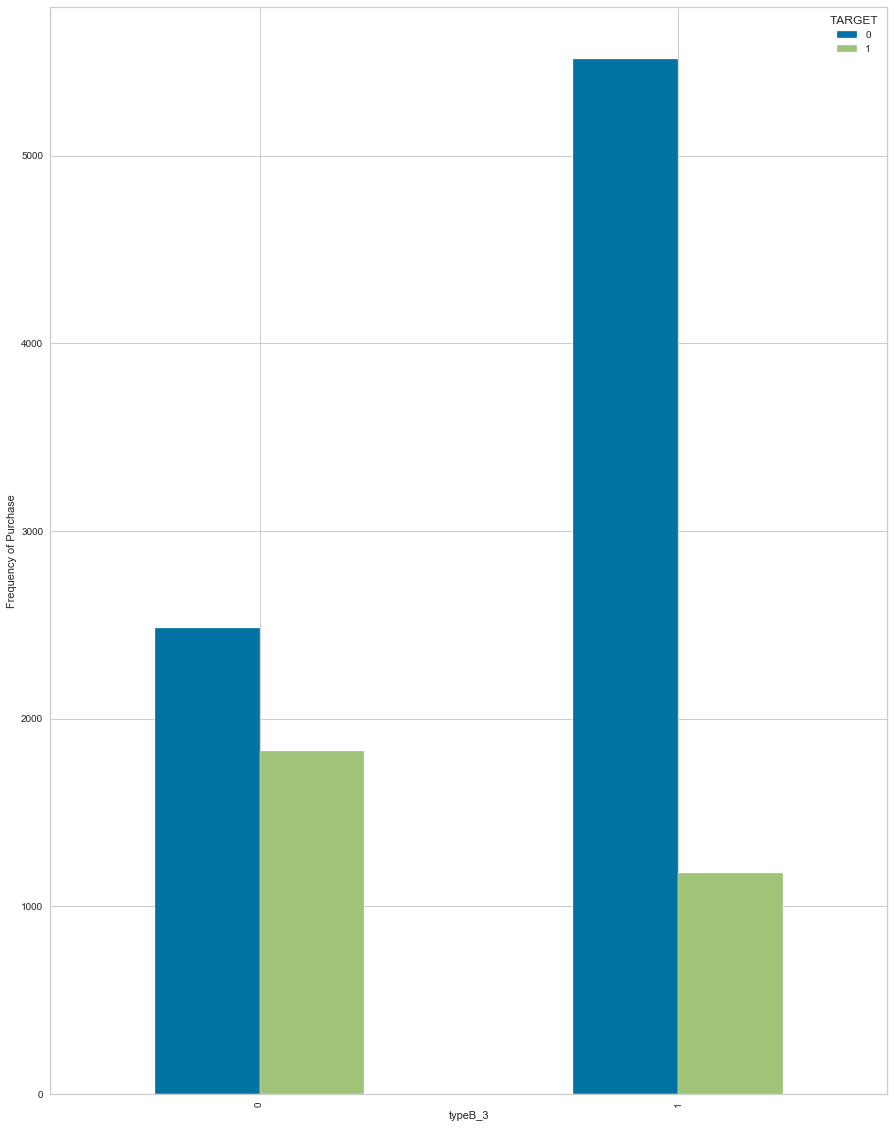

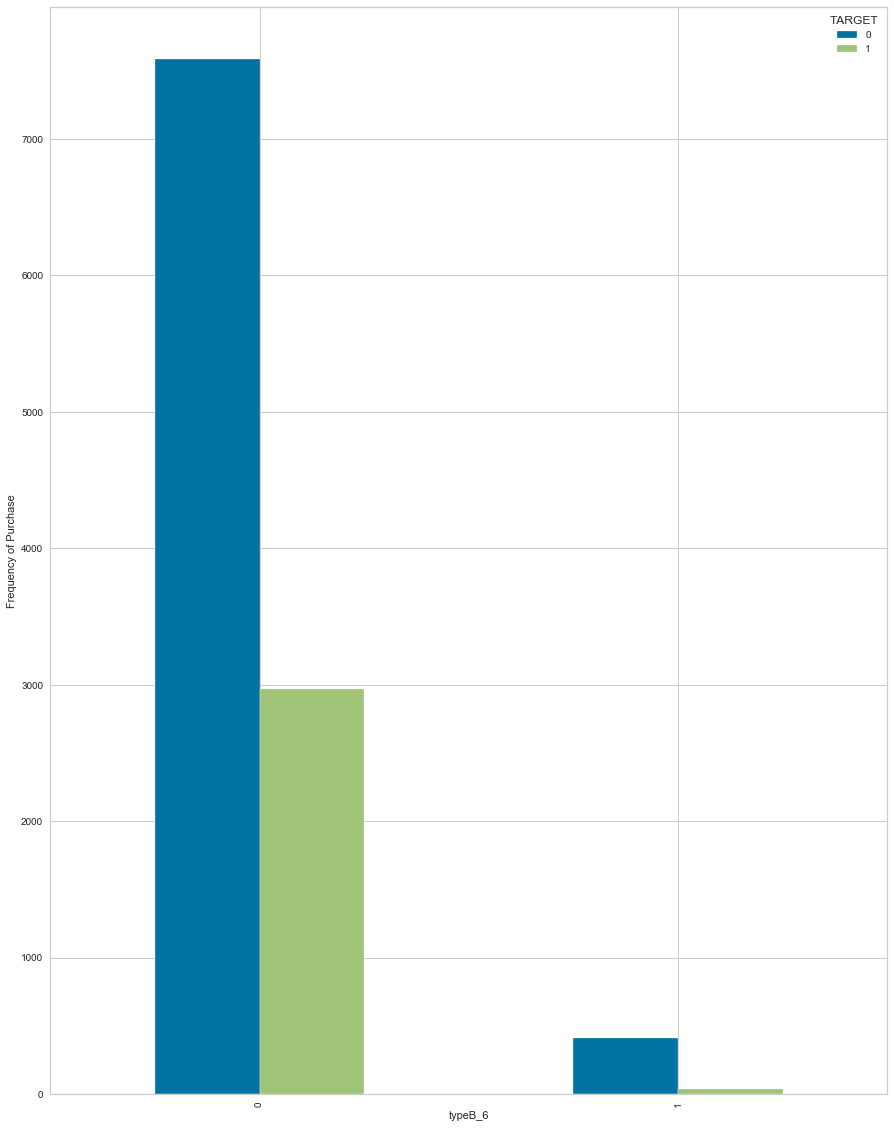

In [80]:
cat = ['loyalty_1', 'loyalty_2', 'loyalty_3','loyalty_99', 'prod_A', 'typeA_0', 'typeA_3', 'prod_B', 'typeB_0', 'typeB_3', 
       'typeB_6']

def crosstab_all(df3,cat):
    for k in cat:
      pd.crosstab(df3[k],df3["TARGET"]).plot(kind='bar')
      plt.xlabel(k)
      plt.ylabel('Frequency of Purchase')

crosstab_all(df3,cat)

Check to see if the predictor variable, TARGET, is balanced.

In [34]:
df3['TARGET'].value_counts()

0    8000
1    3008
Name: TARGET, dtype: int64

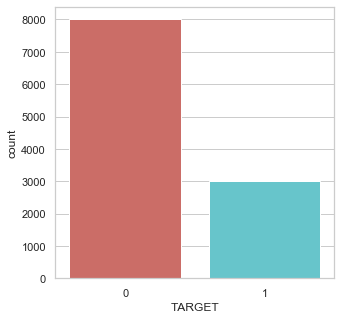

In [35]:
plt.figure(figsize=(5,5))
sns.countplot(x='TARGET', data=df3, palette='hls')
plt.show()

In [36]:
#Calculate the imbalance of TARGET
count_no_prod2 = len(df3[df3['TARGET']==0])
count_prod2 = len(df3[df3['TARGET']==1])
pct_of_no_prod2 = count_no_prod2/(count_no_prod2 + count_prod2)
print("% of no new product is purchased is", round(pct_of_no_prod2 * 100))
pct_of_prod2 = count_prod2/(count_no_prod2 + count_prod2)
print("% of yes a new product is purchased is", round(pct_of_prod2 * 100))

% of no new product is purchased is 73
% of yes a new product is purchased is 27


After the duplicate rows were deleted, the classes of the TARGET variable became imbalanced.  We will need to keep this in mind when training and testing our models.

<h3><b>KNN + SVM Modeling</b></h3>

<b>Feature Selection<b>

Chi-Square Feature Selection for categorical variables

In [37]:
col_cat3=['loyalty_1', 'loyalty_2', 'loyalty_3', 'loyalty_99', 'prod_A', 'typeA_0', 'typeA_3', 'prod_B', 'typeB_0', 
          'typeB_3', 'typeB_6']

#Perform chi-square test
chi_sq=[]
for i in range(0,11):
    chi_sq.append([stats.chi2_contingency(pd.crosstab(df3['TARGET'], df3[col_cat3].iloc[:,i]))[0:2],i])
    
#Chi_sq
chi_sq.sort(reverse=True)
chi_sq

[[(1102.8339097323103, 7.997446982518402e-242), 8],
 [(1102.8339097323103, 7.997446982518402e-242), 7],
 [(945.6020060693334, 1.198839772045794e-207), 6],
 [(945.0489278542645, 1.5812019055507576e-207), 5],
 [(945.0489278542645, 1.5812019055507576e-207), 4],
 [(810.9315410341604, 2.266560521021541e-178), 9],
 [(573.8826849863078, 8.030328831919668e-127), 3],
 [(337.4176978315813, 2.32946552637834e-75), 2],
 [(78.13947565224755, 9.601583081143522e-19), 10],
 [(32.0711491309731, 1.4862822215103112e-08), 1],
 [(24.85171762915519, 6.19138538725396e-07), 0]]

The chi-square test tells us the following columns should be the most significant categorical columns to include in our analysis:<br>
Column 8 - typeB_0 <br>
Column 7 - prod_B <br>
Column 6 - typeA_3 <br>
Column 5 - typeA_0 <br>
Column 4 - prod_A <br>

Logistic Regression Feature Selection

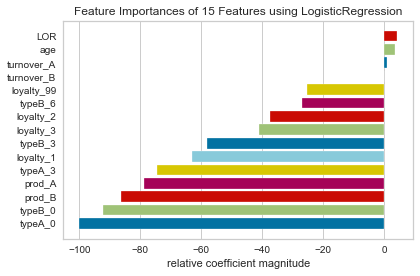

In [38]:
from yellowbrick.classifier import ROCAUC
from yellowbrick.contrib.wrapper import wrap
from yellowbrick.model_selection import FeatureImportances

predictors = ['age', 'LOR', 'loyalty_1', 'loyalty_2', 'loyalty_3', 'loyalty_99', 'prod_A', 'typeA_0', 'typeA_3', 'prod_B',
        'typeB_0', 'typeB_3', 'typeB_6', 'turnover_A', 'turnover_B']

X = df3[predictors]
y = df3.TARGET

lr = LogisticRegression(random_state=42)
fig, ax = plt.subplots(figsize=(6, 4))
fi_viz = FeatureImportances(lr)
fi_viz.fit(X, y)
fi_viz.poof()

Logistic regression selected the same top 5 features but in a slightly different order.  <br>
Logistic regression picked typeA_0, typeB_0, prod_B, prod_A, and typeA_3.<br>
Chi-square picked typeB_0, prod_B, typeA_3, typeA_0, and prod_A.<br>

Determine the optimal number of nearest neighbors to use in our KNN models.

In [39]:
X = df3.iloc[:,1:15]
y = df3.TARGET

#Since our TARGET is imbalanced, we will apply SMOTE to our data set.
import imblearn
from imblearn.over_sampling import SMOTE
X, y  = SMOTE().fit_resample(X, y)

#Prepare data for classification process
#Use 33% data to train 
#Use random state number 20 to make sure result is fixed 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=20)

#According to Chapter 10 of Machine Learning Pocket Reference, distance-based calculations perform better when 
#standized, so we will use StandardScaler from scikit-learn to standardize the data.
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [40]:
#Source: https://www.youtube.com/watch?v=j-uHsi-KjOs

k_values = [i for i in range(1, 50, 2)]

#Empty list that will hold cv scores
k_acc_scores = []

#Function for KNN classifier to find optimal number for k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors = k, n_jobs = -1)
    cv_scores = cross_val_score(knn, X_train, y_train, cv = 5, scoring = 'accuracy')
    k_acc_scores.append(cv_scores.mean())

#Define optimal k
optimal_k = k_values[k_acc_scores.index(max(k_acc_scores))]

print("Our optimal number of nearest neighbors is {}".format(optimal_k))

Our optimal number of nearest neighbors is 5


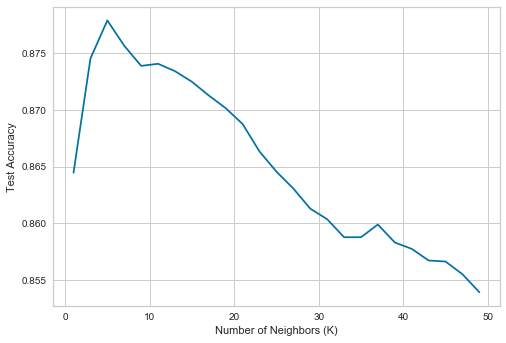

In [41]:
#Accuracy plot for values of k
plt.plot(k_values, k_acc_scores)
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Test Accuracy")
plt.show()

#### Calculate null error rate

In [62]:
#Null error rate
NRE = df3.TARGET.value_counts()[1]/(df3.TARGET.value_counts()[0] + df3.TARGET.value_counts()[1])
Error_Rate = 1 - NRE
Error_Rate

0.7267441860465116

In [63]:
#Training null error rate
training1_NRE = y_train.value_counts()[1]/(y_train.value_counts()[0] + y_train.value_counts()[1])
Null_Error_Rate= 1 - training1_NRE
Null_Error_Rate

0.502705223880597

Our null error rate was previously 72.7% when TARGET was imbalanced.  Now that we have applied SMOTE, the null error rate is 50% which is what we would expect.

<b> KNN Model 1<b>

In [43]:
#Define a vector containing the names of the attributes to use. For this model, we will use the top 5 categorical features
#selected by logistic regression feature selection and the two turnover variables which seems to be predictive of TARGET
#based on our EDA.
predictors = ['typeA_0', 'typeB_0', 'prod_B', 'prod_A', 'typeA_3', 'turnover_A','turnover_B'] 

#Response and explanatory variables
X1 = df3[predictors]
y1 = df3.TARGET

#Apply SMOTE
X1, y1  = SMOTE().fit_resample(df3[predictors], df3.TARGET)

#Prepare data for classification process, use 2/3rds of the data to train, 1/3rd to test, random state of 20.
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.33, random_state=20)

#Create a model
KNN_Classifier = KNeighborsClassifier(n_neighbors = 5, p=2, metric = 'euclidean')

#Train the model
KNN_Classifier.fit(X1_train, y1_train)

KNeighborsClassifier(metric='euclidean')

In [44]:
#Let's predict the classes for training data
y1_train_pred = KNN_Classifier.predict(X1_train)

In [45]:
#Show classification metrics, confusion matrix, f1 score, and score of how well our classifier did.

print(metrics.classification_report(y1_train, y1_train_pred))
print(confusion_matrix(y1_train, y1_train_pred))

p1 = precision_score(y1_train, y1_train_pred)
f1 = f1_score(y1_train, y1_train_pred)
a1 = KNN_Classifier.score(X1_train, y1_train)

print("Precision:", p1) 
print("F1 score:", f1) 
print("Accuracy:", a1)

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      5389
           1       0.91      0.91      0.91      5331

    accuracy                           0.91     10720
   macro avg       0.91      0.91      0.91     10720
weighted avg       0.91      0.91      0.91     10720

[[4908  481]
 [ 501 4830]]
Precision: 0.9094332517416682
F1 score: 0.9077241120090209
Accuracy: 0.9083955223880597


KNN Model 1 has 4,908 true negatives, 481 false positives, 501 false negatives, and 4,830 true positives.<br>
Precision is 90.9%<br>
f1 score is 90.8% <br>
Accuracy is 90.8%<br>

In [93]:
#Evaluate the model using 10-fold cross-validation
#K is often set to a value of 5 or 10 since these values have been shown to produce testing error rate estimates that 
#exhibit neither high bias nor very high variance (see "An Introduction to Statistical Learning", page 184, James, Witten, 
#Hastie, and Tibshirani, ISBN-13: 978-1461471370).  We will use 10 for our K-fold cross validation testing.

from sklearn.model_selection import cross_val_score
scores = cross_val_score(KNN_Classifier, X1_train, y1_train, scoring='accuracy', cv=10)
print(scores)
cv1 = scores.mean()
print("cv_scores_mean:", cv1)

[0.86660448 0.85820896 0.85914179 0.85261194 0.85447761 0.86753731
 0.86007463 0.85541045 0.84981343 0.85541045]
cv_scores_mean: 0.8579291044776118


Our 10-fold cross validation shows that the KNN 1 model has a mean score of 85.8%.

<b> KNN Model 2 <b>

In [69]:
#Define a vector containing the names of the attributes to use. For this model, we will use the top 4 categorical features
#selected by logistic regression feature selection and turnover_A which seems to be predictive of TARGET based on our EDA.
predictors = ['typeA_0', 'typeB_0', 'prod_B', 'prod_A', 'turnover_A'] 

#Response and explanatory variables
X2 = df3[predictors]
y2 = df3.TARGET

#Apply SMOTE
X2, y2  = SMOTE().fit_resample(df3[predictors], df3.TARGET)

#Prepare data for classification process, use 2/3rds of the data to train, 1/3rd to test, random state of 20.
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.33, random_state=20)


#Create a model, p = 2 uses Euclidean Distance
KNN_Classifier2 = KNeighborsClassifier(n_neighbors = 5, p=2, metric = 'euclidean')

#Train the model
KNN_Classifier2.fit(X2_train, y2_train)

KNeighborsClassifier(metric='euclidean')

In [70]:
#Let's predict the classes for training data
y2_train_pred = KNN_Classifier2.predict(X2_train)

In [71]:
#Show classification metrics, confusion matrix, f1 score, and score of how well our classifier did.

print(metrics.classification_report(y2_train, y2_train_pred))
print(confusion_matrix(y2_train, y2_train_pred))

p2 = precision_score(y2_train, y2_train_pred)
f2 = f1_score(y2_train, y2_train_pred)
a2 = KNN_Classifier2.score(X2_train, y2_train)

print("Precision:", p2)
print("F1 score:", f2) 
print("Accuracy:", a2)

              precision    recall  f1-score   support

           0       0.83      0.86      0.84      5389
           1       0.85      0.83      0.84      5331

    accuracy                           0.84     10720
   macro avg       0.84      0.84      0.84     10720
weighted avg       0.84      0.84      0.84     10720

[[4613  776]
 [ 926 4405]]
Precision: 0.8502219648716464
F1 score: 0.838089802130898
Accuracy: 0.8412313432835821


KNN Model 2 has 4,613 true negatives, 776 false positives, 926 false negatives, and 4,405 true positives. <br>
precision is 85%<br>
f1 score is 83.8% <br>
Accuracy is 84.1%.  <br>

In [90]:
#Evaluate the model using 10-fold cross-validation
scores2 = cross_val_score(KNN_Classifier2, X2_train, y2_train, scoring='accuracy', cv=10)
print(scores2)
cv2 = scores2.mean()
print("cv_scores_mean:", cv2)

[0.77705224 0.79011194 0.76399254 0.77518657 0.7630597  0.76865672
 0.77052239 0.78264925 0.75279851 0.77425373]
cv_scores_mean: 0.7718283582089553


Our 10-fold cross validation shows that the KNN 2 model has a mean score of 77.2%.

<b>SVM<b>

First, we must find out if our data is linearly separable to determine if we should use SVM with a linear kernel.

In [49]:
Xs = df3.iloc[:,1:15]
ys = df3.TARGET

Xs, ys  = SMOTE().fit_resample(Xs, ys)

#Prepare data for classification process
#Use 33% data to train 
#Use random state number 20 to make sure result is fixed 
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, test_size=0.33, random_state=20)

#Accodring to Machine Learning Pocket Reference chapter 10, standardizing the data is highly recommended for SVM, so we 
#will use StandardScaler from scikit-learn to standardize the data.
scaler = StandardScaler()
scaler.fit(Xs_train)
Xs_train = scaler.transform(Xs_train)
Xs_test = scaler.transform(Xs_test)

In [50]:
#Import SVM package
from sklearn.svm import SVC

#SVM Model 1 trained with a Linear kernel.
svm=SVC(random_state=42, kernel = "linear", C=1)
svm.fit(Xs_train,ys_train)
svm.score(Xs_train,ys_train)

0.8123134328358209

According to Machine Learning Pocket Reference Chapter 10, C is the penalty parameter.  The smaller the value, the tighter the decision boundary (more overfitting).  If we can overfit with a linear model, that means the data is linearly separable.  For SVM with a linear kernel where C=1, we get an accuracy rate of 81.7%.  We expect to get an accuracy rate of 100% if our data is linearly separable so we conclude that the linear kernel is not the best method and will try rbf.

Source: https://maurygreen.medium.com/how-to-check-for-linear-separability-13c177ae5a6e<br>
Source: https://www.youtube.com/watch?v=TlGpIKMVoOg (around minute 17)

Find the optimal parameters for rbf.

In [51]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'C': [0.5, 1, 10, 100],
              'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']},]

optimal_params = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', verbose = 0)

optimal_params.fit(Xs_train, ys_train)
print(optimal_params.best_params_)

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}


For our data set, the optimal parameters for rbf are C=100 and gamma = 0.1.

<b> SVM Model 1 </b>

In [97]:
#Define a vector containing the names of the attributes to use. For this model, we will use the top 3 categorical features
#chosen by logistic regression feature selection, and turnover_B which seems to be predictive of TARGET
#based on our EDA.
predictors = ['typeA_0', 'typeB_0', 'prod_B', 'turnover_B'] 

#Response and explanatory variables
X3 = df3[predictors]
y3 = df3.TARGET

#Apply SMOTE
X3, y3  = SMOTE().fit_resample(df3[predictors], df3.TARGET)

#Prepare data for classification process, use 2/3rds of the data to train, 1/3rd to test, random state of 20.
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.33, random_state=20)

#Standardize the data
scaler = StandardScaler()
scaler.fit(X3_train)
X3_train = scaler.transform(X3_train)
X3_test = scaler.transform(X3_test)

In [98]:
#SVM Model 1 trained and tested with a radial basis function kernel.
clf1=SVC(random_state = 42, C = 100, gamma = 0.1, kernel = "rbf")
clf1.fit(X3_train, y3_train)
clf1.score(X3_train, y3_train)

#Print metrics
y3_train_pred = clf1.predict(X3_train)

print(classification_report(y3_train, y3_train_pred))
print(confusion_matrix(y3_train, y3_train_pred))

p3 = precision_score(y3_train, y3_train_pred)
f3 = f1_score(y3_train, y3_train_pred)
a3 = metrics.accuracy_score(y3_train, y3_train_pred)

print("Precision:", p3)
print("F1 score:", f3) 
print("Accuracy:", a3)

              precision    recall  f1-score   support

           0       0.69      0.68      0.68      5389
           1       0.68      0.68      0.68      5331

    accuracy                           0.68     10720
   macro avg       0.68      0.68      0.68     10720
weighted avg       0.68      0.68      0.68     10720

[[3670 1719]
 [1686 3645]]
Precision: 0.6795302013422819
F1 score: 0.6816269284712483
Accuracy: 0.6823694029850746


SVM Model 1 has 3,670 true negatives,  1,719 false positives, 1,686 false negatives, and 3,645 true positives.<br>
Precision is 68%<br>
F1 score is 68.2% <br>
Accuracy is 68.2%<br>

In [99]:
#Evaluate the model using 10-fold cross-validation
scores3 = cross_val_score(clf1, X3_train, y3_train, scoring='accuracy', cv=10)
print(scores3)
cv3 = scores3.mean()
print("cv_scores_mean:", cv3)

[0.68283582 0.65578358 0.68190299 0.6613806  0.68283582 0.6744403
 0.68563433 0.67910448 0.69402985 0.66791045]
cv_scores_mean: 0.6765858208955224


Our 10-fold cross validation shows that the SVM 1 model has a mean score of 67.7%.

<b> SVM Model 2<b>

In [74]:
#Define a vector containing the names of the attributes to use.  For this model, we will use 2 categorical features
#chosen by logistic regression feature selection, prod_A and prod_B, and turnover_A and turnover_B which seems to be 
#predictive of TARGET based on our EDA.  
predictors = ['prod_A', 'prod_B', 'turnover_A', 'turnover_B'] 

#Apply SMOTE
X4, y4  = SMOTE().fit_resample(df3[predictors], df3.TARGET)

#Response and explanatory variables
X4 = df3[predictors]
y4 = df3.TARGET

#Prepare data for classification process, use 2/3rds of the data to train, 1/3rd to test, random state of 20.
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.33, random_state=20)

#Standardize the data
scaler = StandardScaler()
scaler.fit(X4_train)
X4_train = scaler.transform(X4_train)
X4_test = scaler.transform(X4_test)

In [75]:
#SVM Model 2 with a radial basis function kernel.
clf2=SVC(random_state = 42, C = 100, gamma = 0.1, kernel = "rbf")
clf2.fit(X4_train, y4_train)
clf2.score(X4_train, y4_train)

#Print metrics
y4_train_pred = clf2.predict(X4_train)

print(classification_report(y4_train, y4_train_pred))
print(confusion_matrix(y4_train, y4_train_pred))

p4 = precision_score(y4_train, y4_train_pred)
f4 = f1_score(y4_train, y4_train_pred)
a4 = metrics.accuracy_score(y4_train, y4_train_pred)

print("Precision:", p4)
print("F1 score:", f4) 
print("Accuracy:", a4)

              precision    recall  f1-score   support

           0       0.86      0.99      0.92      5378
           1       0.96      0.55      0.70      1997

    accuracy                           0.87      7375
   macro avg       0.91      0.77      0.81      7375
weighted avg       0.88      0.87      0.86      7375

[[5327   51]
 [ 903 1094]]
Precision: 0.9554585152838428
F1 score: 0.6963717377466582
Accuracy: 0.8706440677966102


SVM Model 2 has 5,327 true negatives, 51 false positives, 903 false negatives, and 1,094 true positives.<br>
Precision is 95.5%<br>
F1 score is 69.6% <br>
Accuracy is 87.1%<br>

In [88]:
#Evaluate the model using 10-fold cross-validation
scores4 = cross_val_score(clf2, X4_train, y4_train, scoring='accuracy', cv=10)
print(scores4)
cv4 = scores4.mean()
print("cv_scores_mean:", cv4)

[0.87669377 0.86585366 0.8401084  0.86178862 0.87533875 0.8697422
 0.8697422  0.87652646 0.88602442 0.86295794]
cv_scores_mean: 0.8684776413571462


Our 10-fold cross validation shows that the SVM 2 model has a mean score of 86.8%.

Compare the metrics of the training data

In [100]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Table(header=dict(values=['Metrics','KNN 1', 'KNN 2', 'SVM 1', 'SVM 2']),
                 cells=dict(values=[["Precision", "F1 Score", "Accuracy", "CV_scores_mean"],[round(p1,4), round(f1,4), 
                                    round(a1,4), round(cv1,4)], [round(p2,4), round(f2,4), round(a2,4), round(cv2,4)], 
                                    [round(p3,4), round(f3,4), round(a3,4), round(cv3,4)], [round(p4,4), round(f4, 4), 
                                    round(a4,4), round(cv4,4)]]))])
fig.show()

<h3><b>Selected Model</b></h3>

Based on the comparison of our training metrics, our selected model will be our KNN 1 model. While it has seven variables and may not be the easiest to explain, the F1 Score is the highest, and the precision score and the CV_scores_mean are the second highest. This model also has the highest accuracy score. The F1 score conveys the balance between the precision and the recall which can be thought of as the model's exactness and completeness. This is why we are favoring the KNN 1 model.  While the SVM 2 model has the highest precision and cv_scores_mean, the low f1 score is problematic.  We are trying to predict if a customer will purchase an additional insurance product and we can see by the SVM 2 metrics that the model didn't predict those outcomes very well.  

In [77]:
#Let's predict the classes for testing data using KNN Model 1
predicted = KNN_Classifier.predict(X1_test)

In [95]:
print(classification_report(y1_test, predicted))
print(confusion_matrix(y1_test, predicted))

p5 = precision_score(y1_test, predicted)
f5 = f1_score(y1_test, predicted)
a5 = metrics.accuracy_score(y1_test, predicted)

print("Precision:", p5)
print("F1 score:", f5) 
print("Accuracy:", a5)

              precision    recall  f1-score   support

           0       0.85      0.86      0.85      2611
           1       0.86      0.85      0.85      2669

    accuracy                           0.85      5280
   macro avg       0.85      0.85      0.85      5280
weighted avg       0.85      0.85      0.85      5280

[[2239  372]
 [ 400 2269]]
Precision: 0.8591442635365392
F1 score: 0.8546139359698681
Accuracy: 0.8537878787878788


Using KNN Model 1, the testing data has 2,239 true negatives,  372 false positives, 400 false negatives, and 2,269 true positives.<br>
Precision is 85.9%<br>
F1 score is 85.5% <br>
Accuracy is 85.4%<br>

The model performed well to previously unseen data.  The precision, f1 score, and accuracy are all around 85 to 86%.  This is what we would expect since the cv_scores_mean from the training data was 85.79% and that metric tends to predict how well the model will do on unseen data.  

This model performed better than our preferred binary logistic regression model which had a lower precision, f1 score and accuracy score.  

<h3><b>Conclusions</b></h3>

After adjusting our data for an imbalanced response variable, we needed to perform standardization and SMOTE in order to make good use of our models. We used functions to optimize our parameters for our number of nearest neighbor and our rbf models. Our KNN and SVM models made use of the some or all of the top five categorical attributes as decided by logistic regression feature selection, plus floating-point columns such as turnover A and turnover B, which seemed to be predictive of TARGET as determined by our EDA.

Our SVM models made use of only four variables. We intended for these models to be simpler and easier to explain. We noticed we our F1 score dropped off too much with these models.  Even though the first KNN model had the most variables of any of our models, it wasn't that much more computationally expensive than the models with only four variables.

The KNN 1 model outperforms our chosen M7 binary logistic regression model.  When our preferred binary logistic regression model was applied to the testing data, the precision was 90%, the f1 score was 40.6% and the accuracy was 78.7%.  It was our first KNN model that we saw worked the best, was relatively simple, and provided us with robust metrics that we would deem ready for a production environment.  When the testing data was applied to the model, the precision was 85.9%, the f1 score was 85.5% and the accuracy was 85.4%